# **Compute Sentiments Using Python Lexical, ML, DNN and Transformers**

By: Jon Chun
12 Jun 2021

References:

* Coming...

TODO:
* Demo datafiles
* Error detection around Crux points context (out of bounds)
* lex_discrete2continous (research binary->gaussian transformation fn)
* Text Preprocessing hints/tips/flowchart
* Clearly document workflow and partition across notebooks/libraries
* Code review and extraction to libraries
* Corpus ingestion for any format
* XAI (mlm false peak 1717SyuzhetR/1732SentimentR/1797robertalg15 adam watches war argument at dinner) 
* Centralize and Standardize Model name lists
* Normalize model SA Series lengths
* Standardize all SA Series with the same method
* Seamless report generation/file saving
* Get raw text from SentimentR
* Filter out non-printable characters
* Roll-over Crux-Points (SentNo+Sent/Parag) (plotly)
* Label/Roll-over Chapter/Sect No at Boundries
* Generate Report PDF/csv
* Option to select raw or discrete2continous transformation (Bing)
* Annotation functionality + Share/Collaboration of findings/reseearch
* clusters, centroids = kmeans1d.cluster(np.array(corpus_sentimentr_df['jockers_rinker']), k)
* plotly prefered library to save dynamic images: kaleido
* Correlation heatmaps: Justify choice of Spearman, Pearson, or other algo

Facts:
* SyuzhetR vs SentimentTime Clean/Preprocess
* V.Woolf - To The Lighthouse
* SyuzhetR Clean: 3511 (SyuzhetR Preprocessed) Sentences (SentimentTime Preprocessed) 3403
* SentimentTime Clean: (Raw) 3402  (Clean) 3402


Preprocessing of Corpus Textfile
* Put headers in ALL CAPS
* Put \n\n between each CHAPTER/BOOK or SECTION header or Paragraphs
* Keep your format/spacing consistent
* Try to use utf-8 (not cp1252 (e.g. \n <- \n\r)
* No leading blank lines, one trailing blank line at end of textfile
* Check for illegal, non-printable or other problematic code (e.g. curly single/double quotes)

# **Reference Code**

Surveys:
* https://github.com/prrao87/fine-grained-sentiment (20210409) Fine-grained SA (7 Models)


Other:
* https://github.com/annabiancajones/GA_capstone_project/blob/master/part3_mine_refine.ipynb
* https://towardsdatascience.com/train-test-split-and-cross-validation-in-python-80b61beca4b6 CV

In [1]:
!nvidia-smi

Tue Mar  1 21:27:17 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# **Installs Requiring [Restart Runtime]**

In [2]:
import torch
torch.cuda.is_available()

True

In [5]:
!pip install transformers

In [6]:
%%time

# NOTE: 

# Required by Transformer Models: All
import transformers
from transformers import pipeline

# Required by Transformer Models: Yelp, Hinglish
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AutoModelForSeq2SeqLM

CPU times: user 2.85 s, sys: 507 ms, total: 3.35 s
Wall time: 3.43 s


In [46]:
# [RESTART RUNTIME] May be Required

# Designed Security Hole in older version of PyYAML
#   must upgrade to use plotly

# !pip install pyyaml==5.4.1

# [STEP 1] Manual Configuration

## [INPUT] Connect Google gDrive to this Jupyter Notebook

In [7]:
# [INPUT REQUIRED]: Authorize access to Google gDrive

# Connect this Notebook to your permanent Google Drive
#   so all generated output is saved to permanent storage there

try:
  from google.colab import drive
  IN_COLAB=True
except:
  IN_COLAB=False

if IN_COLAB:
  print("Attempting to attach your Google gDrive to this Colab Jupyter Notebook")
  drive.mount('/gdrive')
else:
  print("Your Google gDrive is attached to this Colab Jupyter Notebook")

Attempting to attach your Google gDrive to this Colab Jupyter Notebook
Mounted at /gdrive


In [8]:
# [CUSTOMIZE]: Change the text after the Unix '%cd ' command below (change directory)
#              to math the full path to your gDrive subdirectory which should be the 
#              root directory cloned from the SentimentArcs github repo.

# NOTE: Make sure this subdirectory already exists and there are 
#       no typos, spaces or illegals characters (e.g. periods) in the full path after %cd

# NOTE: In Python all strings must begin with an upper or lowercase letter, and only
#         letter, number and underscores ('_') characters should appear afterwards.
#         Make sure your full path after %cd obeys this constraint or errors may appear.



# Step #1: Get full path to SentimentArcs subdir on gDrive
# =======
#@markdown **Accept default path on gDrive or Enter new one:**

Path_to_SentimentArcs = "/gdrive/MyDrive/cdh/sentiment_arcs/" #@param ["/gdrive/MyDrive/sentiment_arcs/"] {allow-input: true}

#@markdown (e.g. /gdrive/MyDrive/research/sentiment_arcs/)



# Step #2: Move to Parent directory of Sentiment_Arcs
# =======
parentdir_sentiment_arcs = '/'.join(Path_to_SentimentArcs.split('/')[:-2])
print(f'subdir_parent: {parentdir_sentiment_arcs}')
%cd $parentdir_sentiment_arcs


# Step #3: If project sentiment_arcs subdir does not exist, 
#          clone it from github
# =======
import os

if not os.path.isdir('sentiment_arcs'):
  # NOTE: This will not work until SentimentArcs becomes an open sourced PUBLIC repo
  # !git clone https://github.com/jon-chun/sentiment_arcs.git

  # Test on open access github repo
  !git clone https://github.com/jon-chun/nabokov_palefire.git


# Step #4: Change into sentiment_arcs subdir
# =======
%cd ./sentiment_arcs
# Test on open acess github repo
# %cd ./nabokov_palefire

# Step #5: Confirm contents of sentiment_arcs subdir
# =======
!ls


subdir_parent: /gdrive/MyDrive/cdh
/gdrive/MyDrive/cdh
/gdrive/MyDrive/cdh/sentiment_arcs
 catboost_info				 learing_rate_0.01      sentiment_clean
 config					 learing_rate_0.7       sentiment_raw
 data					 lexicons	        sentinet.rda
 docs					 lmcd.rda	        sentiword.rda
 fastText-0.9.2				 loughranmcdonald.rda   SentiWord.rda
 get_sentimentr.R			 models__info.yaml      text_clean
 huliu.rda				 notebooks	        text_raw
'IMDB Dataset.csv'			 nrc.rda	        utils
 imdb-dataset-of-50k-movie-reviews.zip	 plots		        v0.9.2.zip
 jockersrinker.rda			 senticnet.rda	        v0.9.2.zip.1


In [9]:
# [VERIFY]: Ensure that all the manually preprocessed novel are in plain text
#   files and file names are formatted correctly

# %cd ../sentiment_arcs
!pwd
!ls ./text_raw

/gdrive/MyDrive/cdh/sentiment_arcs
finance_text_new_raw  novels_text_new_raw  social_text_new_raw
finance_text_ref_raw  novels_text_ref_raw  social_text_ref_raw


## [INPUT] Define Directory Tree Structure

In [10]:
#@markdown **Sentiment Arcs Directory Structure** \
#@markdown \
#@markdown **1. Input Directories:** \
#@markdown (a) Raw textfiles in subdir: ./text_raw/(text_type)/  \
#@markdown (b) Cleaned textfiles in subdir: ./text_clean/(text_type)/ \
#@markdown \
#@markdown **2. Output Directories** \
#@markdown (1) Raw Sentiment time series datafiles and plots in subdir: ./sentiment_raw/(text_type) \
#@markdown (2) Cleaned Sentiment time series datafiles and plots in subdir: ./sentiment_clean/(text_type) \
#@markdown \
#@markdown **Which type of texts are you analyzing?** \

Text_Type = "novels" #@param ["novels", "social_media", "finance"]

Corpus = "new_texts" #@param ["reference_corpora", "new_texts"]

#@markdown Please check that the required textfiles and datafiles exist in the correct subdirectories before continuing.


In [11]:
# Create Directory CONSTANTS based On Document Type

if Corpus == "new_texts":
  Corpus_Type = "new"
else:
  Corpus_Type = "ref"

# Project Subdirs
SUBDIR_TEXT_RAW = f"./text_raw/{Text_Type}_text_{Corpus_Type}_raw/"
SUBDIR_TEXT_CLEAN = f"./text_clean/{Text_Type}_text_{Corpus_Type}_clean/"
SUBDIR_SENTIMENT_RAW = f"./sentiment_raw/{Text_Type}_sentiment_{Corpus_Type}_raw/"
SUBDIR_SENTIMENT_CLEAN = f"./sentiment_clean/{Text_Type}_sentiment_{Corpus_Type}_clean/"
SUBDIR_PLOTS = f"./plots/{Text_Type}_plots/"

# Destination filename to save raw sentiments 
FNAME_SENTIMENT_RAW = f'sentiment_raw_{Text_Type}_{Corpus_Type}_dnn2transformer.json'

# Verify Directory Structure

print('Verify the Directory Structure:\n')
print('-------------------------------\n')

print(f'           [Corpus Type]: {Text_Type}\n')
print(f'       [SUBDIR_TEXT_RAW]: {SUBDIR_TEXT_RAW}\n')
print(f'     [SUBDIR_TEXT_CLEAN]: {SUBDIR_TEXT_CLEAN}\n')
print(f'  [SUBDIR_SENTIMENT_RAW]: {SUBDIR_SENTIMENT_RAW}\n')
print(f'[SUBDIR_SENTIMENT_CLEAN]: {SUBDIR_SENTIMENT_CLEAN}\n')
print(f'          [SUBDIR_PLOTS]: {SUBDIR_PLOTS}\n')

print('\n\nVerify the Raw Sentiment Desitnation Datafile:\n')
print('----------------------------------------------\n')

print(f'   [FNAME_SENTIMENT_RAW]: {FNAME_SENTIMENT_RAW}\n')


Verify the Directory Structure:

-------------------------------

           [Corpus Type]: novels

       [SUBDIR_TEXT_RAW]: ./text_raw/novels_text_new_raw/

     [SUBDIR_TEXT_CLEAN]: ./text_clean/novels_text_new_clean/

  [SUBDIR_SENTIMENT_RAW]: ./sentiment_raw/novels_sentiment_new_raw/

[SUBDIR_SENTIMENT_CLEAN]: ./sentiment_clean/novels_sentiment_new_clean/

          [SUBDIR_PLOTS]: ./plots/novels_plots/



Verify the Raw Sentiment Desitnation Datafile:

----------------------------------------------

   [FNAME_SENTIMENT_RAW]: sentiment_raw_novels_new_dnn2transformer.json



# **[STEP 2] Automatic Configuration**

## Configure Jupyter Notebook

In [12]:
# Ignore warnings

import warnings
warnings.filterwarnings('ignore')

In [13]:
# Configure Jupyter

# Enable multiple outputs from one code cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

from IPython.display import display
from IPython.display import Image
from ipywidgets import widgets, interactive

## Read YAML Configuration File

In [14]:
!pip install pyyaml
import yaml

In [15]:
# Read SentimentArcs YAML Config Files for Different Corpora Types(3) and Text Files Details

# Read SentimentArcs YAML Config Files on Models

# Model in SentimentArcs Ensemble
with open("./config/models_ref_info.yaml", "r") as stream:
  try:
    models_titles_dt = yaml.safe_load(stream)
  except yaml.YAMLError as exc:
    print(exc)

if Text_Type == 'novels':

  # Novel Text Files
  if Corpus == 'new_texts':
    # Corpus of New Novels
    with open("./config/novels_new_info.yaml", "r") as stream:
      try:
        corpus_titles_dt = yaml.safe_load(stream)
      except yaml.YAMLError as exc:
        print(exc)
  else:
    # Corpus of Reference Novels
    with open("./config/novels_ref_info.yaml", "r") as stream:
      try:
        corpus_titles_dt = yaml.safe_load(stream)
      except yaml.YAMLError as exc:
        print(exc)    

elif Text_Type == 'finance':

  # Finance Text Files
  if Corpus == 'new_texts':
    # Corpus of New Finance Texts
    with open("./config/finance_new_info.yaml", "r") as stream:
      try:
        corpus_titles_dt = yaml.safe_load(stream)
      except yaml.YAMLError as exc:
        print(exc)
  else:
    # Corpus of Reference Finance Texts
    with open("./config/finance_ref_info.yaml", "r") as stream:
      try:
        corpus_titles_dt = yaml.safe_load(stream)
      except yaml.YAMLError as exc:
        print(exc)

elif Text_Type == 'social_media':

  # Social Media Text Files
  if Corpus == 'new_texts':
    # Corpus of New Social Media Texts
    with open("./config/social_new_info.yaml", "r") as stream:
      try:
        corpus_titles_dt = yaml.safe_load(stream)
      except yaml.YAMLError as exc:
        print(exc)
  else:
    # Corpus of Reference Social Media Texts
    with open("./config/social_ref_info.yaml", "r") as stream:
      try:
        corpus_titles_dt = yaml.safe_load(stream)
      except yaml.YAMLError as exc:
        print(exc)

else:
  
  print(f"ERROR: Illegal Text_Type: {Text_Type}\n")

print(f'Corpus Titles Dictionary =')
corpus_titles_dt.keys()

print(f'\n\nThe Corpus Titles contains [{len(corpus_titles_dt.keys())} {Text_Type}] textfiles ')
print(f'\nFirst Text in Corpus:')
print(corpus_titles_dt[next(iter(corpus_titles_dt))])

Corpus Titles Dictionary =


dict_keys(['scollins_thehungergames1', 'cmieville_thecityandthecity'])



The Corpus Titles contains [2 novels] textfiles 

First Text in Corpus:
['The Hunger Games 1 by Suzanne Collins ', 2008, 0]


In [16]:
import json

In [17]:
# Verify the Corpora Text Titles

print(json.dumps(corpus_titles_dt, indent=2))

{
  "scollins_thehungergames1": [
    "The Hunger Games 1 by Suzanne Collins ",
    2008,
    0
  ],
  "cmieville_thecityandthecity": [
    "The City and The City by China Mieville",
    2009,
    0
  ]
}


In [18]:
# Verfiy all 34 Sentiment Models in SentimentArcs Ensemble

print(json.dumps(models_titles_dt, sort_keys=True, indent=2))

{
  "AutoGluon_Text": [
    "autogluon",
    "tradml",
    "autogluon_text"
  ],
  "BERT_2IMDB": [
    "imdb2way",
    "transformer",
    "bert"
  ],
  "BERT_Dual_Coding": [
    "hinglish",
    "transformer",
    "bert"
  ],
  "BERT_Multilingual": [
    "nlptown",
    "transformer",
    "bert"
  ],
  "BERT_Yelp": [
    "yelp",
    "transformer",
    "bert"
  ],
  "CNN_DNN": [
    "cnn",
    "dnn",
    1315937
  ],
  "Distilled_BERT": [
    "huggingface",
    "transformer",
    "bert"
  ],
  "FLAML_AutoML": [
    "flaml",
    "tradml",
    "flaml"
  ],
  "Fully_Connected_Network": [
    "fcn",
    "dnn",
    6287671
  ],
  "HyperOpt_CNN_Flair_AutoML": [
    "flair",
    "dnn",
    0
  ],
  "LSTM_DNN": [
    "lstm",
    "dnn",
    7109089
  ],
  "Logistic_Regression": [
    "logreg",
    "tradml",
    "scikit"
  ],
  "Logistic_Regression_CV": [
    "logreg_cv",
    "tradml",
    "scikit"
  ],
  "Multilingual_CNN_Stanza_AutoML": [
    "stanza",
    "dnn",
    0
  ],
  "Multinomial_Naive_B

## Install Libraries: Python

In [22]:
import numpy as np

from tqdm._tqdm_notebook import tqdm_notebook
import pandas as pd
tqdm_notebook.pandas()

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
pd.set_option('max_colwidth', 100) # -1)

In [23]:
from glob import glob
import copy
import json

In [24]:
# Plotly Visualizations

# import plotly.graph_objects as go
# import plotly.express as px
# import plotly

In [25]:
# Scikit Utilities, Metrics, Pipelines and Models

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from sklearn.metrics import plot_confusion_matrix, plot_roc_curve, plot_precision_recall_curve

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer

from sklearn.pipeline import Pipeline
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB


## Setup Matplotlib Style

* https://matplotlib.org/stable/tutorials/introductory/customizing.html

In [37]:
from cycler import cycler

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']   
linestyles = ['-', '--', ':', '-.','-', '--', ':', '-.','-', '--']

cycle = plt.cycler("color", colors) + plt.cycler("linestyle", linestyles)

# View previous matplotlib configuration
print('\n Old Matplotlib Configurtion Settings:\n')
# plt.rc.show
print('\n\n')

# Update and view new matplotlib configuration
print('\n New Matplotlib Configurtion Settings:\n')
myparams = {'axes.prop_cycle': cycle}
plt.rcParams.update(myparams)

plt.rcParams["axes.titlesize"] = 16
plt.rcParams['figure.figsize'] = 20,10
plt.rcParams["legend.fontsize"] = 10
plt.rcParams["xtick.labelsize"] = 12
plt.rcParams["ytick.labelsize"] = 12
plt.rcParams["axes.labelsize"] = 12
plt.rcParams["figure.titlesize"] = 32

# View matplotlib options
# plt.rcParams.keys()


 Old Matplotlib Configurtion Settings:





 New Matplotlib Configurtion Settings:



In [38]:
"""
import matplotlib.colors as mcolors

mcolors.TABLEAU_COLORS

all_named_colors = {}
all_named_colors.update(mcolors.TABLEAU_COLORS)

print('\n')
all_named_colors.values()
""";

In [39]:
# Set matplotlib plot figure.figsize

new_plt_size = plt.rcParams["figure.figsize"]=(20,10)

print(" New figure size: ",new_plt_size)

 New figure size:  (20, 10)


## Setup Seaborn Style

In [40]:
# View previous seaborn configuration
print('\n Old Seaborn Configurtion Settings:\n')
sns.axes_style()
print('\n\n')

# Update and View new seaborn configuration
print('\n New Seaborn Configurtion Settings:\n')
# sns.set_style('white')
sns.set_context('paper')
sns.set_style('white')
sns.set_palette('tab10')

# Change defaults
# sns.set(style='white', context='talk', palette='tab10')


 Old Seaborn Configurtion Settings:



{'axes.axisbelow': True,
 'axes.edgecolor': '.8',
 'axes.facecolor': 'white',
 'axes.grid': True,
 'axes.labelcolor': '.15',
 'axes.spines.bottom': True,
 'axes.spines.left': True,
 'axes.spines.right': True,
 'axes.spines.top': True,
 'figure.facecolor': 'white',
 'font.family': ['sans-serif'],
 'font.sans-serif': ['Arial',
  'Liberation Sans',
  'DejaVu Sans',
  'Bitstream Vera Sans',
  'sans-serif'],
 'grid.color': '.8',
 'grid.linestyle': '-',
 'image.cmap': 'Greys',
 'lines.solid_capstyle': 'round',
 'patch.edgecolor': 'w',
 'patch.force_edgecolor': True,
 'text.color': '.15',
 'xtick.bottom': False,
 'xtick.color': '.15',
 'xtick.direction': 'out',
 'xtick.top': False,
 'ytick.color': '.15',
 'ytick.direction': 'out',
 'ytick.left': False,
 'ytick.right': False}





 New Seaborn Configurtion Settings:



In [41]:
# Seaborn: Set Theme (Scale of Font)

sns.set_theme('paper')  # paper, notebook, talk, poster


# Seaborn: Set Context
# sns.set_context("notebook")



# Seaborn: Set Style

# sns.set_style('ticks') # darkgrid, whitegrid, dark, white, and ticks

In [42]:
# Seaborn: Default Palette (Pastel?)

sns.color_palette()

[(0.2980392156862745, 0.4470588235294118, 0.6901960784313725),
 (0.8666666666666667, 0.5176470588235295, 0.3215686274509804),
 (0.3333333333333333, 0.6588235294117647, 0.40784313725490196),
 (0.7686274509803922, 0.3058823529411765, 0.3215686274509804),
 (0.5058823529411764, 0.4470588235294118, 0.7019607843137254),
 (0.5764705882352941, 0.47058823529411764, 0.3764705882352941),
 (0.8549019607843137, 0.5450980392156862, 0.7647058823529411),
 (0.5490196078431373, 0.5490196078431373, 0.5490196078431373),
 (0.8, 0.7254901960784313, 0.4549019607843137),
 (0.39215686274509803, 0.7098039215686275, 0.803921568627451)]

In [43]:
# Seaborn: Set to High-Contrast Palette (more Vision Impaired Friendly)

sns.set_palette('tab10')
sns.color_palette()

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529)]

In [44]:
plt.style.available

['Solarize_Light2',
 '_classic_test_patch',
 'bmh',
 'classic',
 'dark_background',
 'fast',
 'fivethirtyeight',
 'ggplot',
 'grayscale',
 'seaborn',
 'seaborn-bright',
 'seaborn-colorblind',
 'seaborn-dark',
 'seaborn-dark-palette',
 'seaborn-darkgrid',
 'seaborn-deep',
 'seaborn-muted',
 'seaborn-notebook',
 'seaborn-paper',
 'seaborn-pastel',
 'seaborn-poster',
 'seaborn-talk',
 'seaborn-ticks',
 'seaborn-white',
 'seaborn-whitegrid',
 'tableau-colorblind10']

In [45]:
plt.style.use('seaborn-whitegrid')

## Define Globals

In [46]:
# Main Dictionary holding all Lexicon by Name/Key

lexicons_dt = {}


# Test WORDS of Sentiment Analysis
test_words_ls =["Love",
                "Hate",
                "bizarre",
                "strange",
                "furious",
                "elated",
                "curious",
                "beserk",
                "gambaro"]


# Test SENTENCES of Sentiment Analysis
test_sentences_ls =["I hate bad evil worthless Mondays.",
                    "I love Paris in the springtime",
                    "It was Wednesday.",
                    "You are a disgusting pig - I hate you.",
                    "What a delightfully funny and beautiful good man.",
                    "That was it"]

## Python Utility Functions

In [47]:
# NOTE: SentimentArcs Main datastructure is a Dictionary(Corpus) of DataFrames(Documents: rows=sentences, cols=sentiment, 1 col per model in ensemble)
#       This complex data structure has 2 special I/O utility functions to read/write to permanent disk storage as *.json files

# Utility functions to read/write nested Dictionary (key=novel) of DataFrames (Cols = Model Sentiment Series) 

def write_dict_dfs(adict, out_file='sentiments.json', out_dir=SUBDIR_SENTIMENT_RAW):
  '''
  Given a Dictionary of DataFrames and optional output filename and output directory
  Write as nested json file
  '''

  # convert dataframes into dictionaries
  data_dict = {
      key: adict[key].to_dict(orient='records') 
      for key in adict.keys()
  }

  # write to disk
  out_fullpath = f'{out_dir}{out_file}'
  print(f'Saving file to: {out_fullpath}')
  with open(out_fullpath, 'w') as fp:
    json.dump(
      data_dict, 
      fp, 
      indent=4, 
      sort_keys=True
    )

  return 

def read_dict_dfs(in_file='sentiments.json', in_dir=SUBDIR_SENTIMENT_RAW):
  '''
  Given a Dictionary of DataFrames and optional output filename and output directory
  Read nested json file into Dictionary of DataFrames
  '''

  # read from disk
  in_fullpath = f'{in_dir}{in_file}'
  with open(in_fullpath, 'r') as fp:
      data_dict = json.load(fp)

  # convert dictionaries into dataframes
  all_dt = {
      key: pd.DataFrame(data_dict[key]) 
      for key in data_dict
  }

  return all_dt

# **[STEP 3] Read Clean Corpus Texts and any Existing Raw Sentiment Data**

In [48]:
subdir_sentiment_raw_ls = os.listdir(SUBDIR_SENTIMENT_RAW)
print(f'SUBDIR_SENTIMENT_RAW: {subdir_sentiment_raw_ls}')

"""
  print(f'\n\n!!!!!!!!!! <<< ERROR >>> !!!!!!!!!!\n\n')
  print(f'[SOLUTION]:\n')
  print(f'This file does not exist, so there is no data for the models in this Notebook')
  print(f'Goto [Option (b)] below and continue running this Notebook from there')
""";

SUBDIR_SENTIMENT_RAW: ['all_novels_new_4syuzhetr.json', 'all_novels_new_7sentimentr.json', 'all_novels_new_lex_ml_dnn.json', 'sentiment_raw_novels_new_lex2ml.json', 'sentiment_raw_novels_new_dnn2transformer.json']


In [49]:
print(f'Trying to find EXISTING Raw Sentiment Datafile:\n  [{FNAME_SENTIMENT_RAW}]\n  in Raw Sentiment Subdir: {SUBDIR_SENTIMENT_RAW}\n')

corpus_texts_dt = {}
subdir_sentiment_raw_ls = os.listdir(SUBDIR_SENTIMENT_RAW)

if FNAME_SENTIMENT_RAW not in subdir_sentiment_raw_ls:
  # No Existing Raw Sentiment Data, Just read in Clean Text
  print(f'No EXISTING Lex2ML Raw Sentiment Datafile exists, Start from Stratch...\n')

  # Create a List (preprocessed_ls) of all preprocessed text files
  try:
    preprocessed_ls = glob(f'{SUBDIR_TEXT_CLEAN}*.csv')
    preprocessed_ls = [x.split('/')[-1] for x in preprocessed_ls]
    preprocessed_ls = [x.split('.')[0] for x in preprocessed_ls]
  except IndexError:
    raise RuntimeError('No csv file found')

  # Read all preprocessed text files into master DataFrame (corpus_dt)
  for i,anovel in enumerate(preprocessed_ls):
    print(f'Processing #{i}: {anovel}...')
    afile_fullpath = f'{SUBDIR_TEXT_CLEAN}{anovel}.csv'
    print(f'               {afile_fullpath}')
    anovel_df = pd.read_csv(afile_fullpath, index_col=[0])
    corpus_texts_dt[anovel] = anovel_df

  print('\n'.join(preprocessed_ls))
  print('\n')
  print(f'Found {len(preprocessed_ls)} Preprocessed files in {SUBDIR_TEXT_CLEAN}')
else:
  # Found Existing Raw Sentiment Data with Clean Text, Read Both
  print(f'Found EXISTING Lex2ML Raw Sentiment Datafile exists, Loading...\n')
  corpus_texts_dt = read_dict_dfs(in_file=FNAME_SENTIMENT_RAW, in_dir=SUBDIR_SENTIMENT_RAW)
  print(f'The Lex2ML Models have Analyzed these Texts in the Corpus:\n\n  {corpus_texts_dt.keys()}\n\n')    

# Verify Corpus DataFrame
corpus_titles_ls = list(corpus_texts_dt.keys())
# corpus_texts_dt[corpus_titles_ls[0]].head()
corpus_texts_dt[corpus_titles_ls[0]].info()

Trying to find EXISTING Raw Sentiment Datafile:
  [sentiment_raw_novels_new_dnn2transformer.json]
  in Raw Sentiment Subdir: ./sentiment_raw/novels_sentiment_new_raw/

Found EXISTING Lex2ML Raw Sentiment Datafile exists, Loading...

The Lex2ML Models have Analyzed these Texts in the Corpus:

  dict_keys(['cmieville_thecityandthecity', 'scollins_thehungergames1'])


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10125 entries, 0 to 10124
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   huggingface  10125 non-null  float64
 1   roberta15lg  10125 non-null  float64
 2   text_clean   10125 non-null  object 
 3   text_raw     10125 non-null  object 
dtypes: float64(2), object(2)
memory usage: 316.5+ KB


# **[STEP 4] DNN Models**

In [37]:
# Get global list of Corpus Titles/Keys into Dictionary corpus_texts_dt

corpus_titles_ls = list(corpus_texts_dt.keys())
corpus_titles_ls

['cmieville_thecityandthecity', 'scollins_thehungergames1']

## **Model Utilities**

In [ ]:
# https://www.kaggle.com/aditya6040/7-models-on-imdb-dataset-best-score-88-2/notebook

def metrics(model,x,y):
    y_pred = model.predict(x)
    acc = accuracy_score(y, y_pred)
    f1=f1_score(y, y_pred)
    cm=confusion_matrix(y, y_pred)
    report=classification_report(y,y_pred)
    plt.figure(figsize=(4,4))
    sns.heatmap(cm,annot=True,cmap='Blues',xticklabels=[0,1],fmt='d',annot_kws={"fontsize":19})
    plt.xlabel("Predicted",fontsize=16)
    plt.ylabel("Actual",fontsize=16)
    plt.show()
    print("\nAccuracy: ",round(acc,2))
    print("\nF1 Score: ",round(f1,2))
#     print("\nConfusion Matrix: \n",cm)
    print("\nReport:",report)

In [ ]:
def lexicon_metrics(y, y_pred):
    acc = accuracy_score(y, y_pred)
    f1=f1_score(y, y_pred)
    cm=confusion_matrix(y, y_pred)
    report=classification_report(y, y_pred)
    plt.figure(figsize=(4,4))
    sns.heatmap(cm,annot=True,cmap='Blues',xticklabels=[0,1],fmt='d',annot_kws={"fontsize":19})
    plt.xlabel("Predicted",fontsize=16)
    plt.ylabel("Actual",fontsize=16)
    plt.show()
    print("\nAccuracy: ",round(acc,2))
    print("\nF1 Score: ",round(f1,2))
#     print("\nConfusion Matrix: \n",cm)
    print("\nReport:",report)

## **Deep Neural Networks**

* https://github.com/thoailinh/Sentiment-Analysis-using-BERT (Viet Comparison)

* https://github.com/Feuoy/sentiment-analysis (Chinese Comparison)

* https://www.kaggle.com/aditya6040/7-models-on-imdb-dataset-best-score-88-2/notebook#CNN-Model
* https://github.com/bentrevett/pytorch-sentiment-analysis

* https://github.com/nileshsah/deep-text-classifier/blob/master/inshorts_notebook.ipynb
* https://github.com/saurabhrathor/InceptionModel_SentimentAnalysis (fasttext emb CNN+LSTM) BB_twtr SemEval2017
* https://github.com/kaliahinartem/twitter_sentiment_analysis
* https://github.com/leelaylay/TweetSemEval


### **Common Setup**

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Dropout

from keras.wrappers.scikit_learn import KerasClassifier

from keras.preprocessing import text, sequence
from keras import layers, models, optimizers

In [ ]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import ModelCheckpoint
from keras.layers import LSTM,Dropout
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.layers import LSTM, Conv1D, MaxPooling1D, Dropout
from keras.callbacks import EarlyStopping

In [ ]:
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

In [ ]:
training_df.info()

In [ ]:
# Split labeled dataset into training, validation and test sets
# e.g. for IMDB 50k reviews: Out of 50k dataset, 36k for training, 4k for Validationa and 10k for testing

X_train, X_test, y_train, y_test = train_test_split(training_df['text_raw'], training_df['polarity'],test_size=0.2, random_state=0)

X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train,test_size=0.1, random_state=0)

[x.shape for x in [X_train,X_valid,X_test]]


In [ ]:
X_train.shape
print('\n')
type(X_train)

In [ ]:
type(X_train)

In [ ]:
X_train[:2]

In [ ]:
%%time

# Tokenize text

tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(training_df.text_raw)

X_train1 = tokenizer.texts_to_sequences(X_train)
X_valid1 = tokenizer.texts_to_sequences(X_valid)
X_test1 = tokenizer.texts_to_sequences(X_test)

vocab_size = len(tokenizer.word_index) + 1  # Adding 1 because of reserved 0 index

print(X_train[2])
print(X_train1[2])

In [ ]:
type(X_train1)
print('\n')
X_train1

In [ ]:
corpus_sents_df.head()

In [ ]:
corpus_sents_df['sent_clean'] = corpus_sents_df['sent_clean'].astype('string')
X_corpus_ser = corpus_sents_df['sent_clean']
type(X_corpus_ser)
X_corpus_ser[:2]

In [ ]:
X_corpus1 = tokenizer.texts_to_sequences(X_corpus_ser)
type(X_corpus1)
X_corpus_ser[4]
X_corpus1[4]

In [ ]:
"""
X_corpus = np.asarray(tokenizer.texts_to_sequences(X_corpus_ser)) # , dtype=int)
X_corpus.shape
type(X_corpus)
X_corpus
""";

In [ ]:
"""
X_corpus = np.array(tokenizer.texts_to_sequences(corpus_sents_df['sent_clean'])) # , dtype=int)
X_corpus.shape
type(X_corpus)
X_corpus
""";

In [ ]:
"""
tokens_ls_ls = tokenizer.texts_to_sequences(corpus_sents_df['sent_clean'])
X_corpus_ar = np.array([np.array(lsi) for lsi in tokens_ls_ls])
X_corpus_ar
""";

In [ ]:
"""
X_corpus = np.asarray(tokenizer.texts_to_sequences(corpus_sents_df['sent_clean'])) # , dtype=int)
# X_corpus = X_corpus.astype('int32')
# npa = np.asarray(someListOfLists, dtype=np.float32)
X_corpus[:3]
print('\n')
type(X_corpus)
""";

In [ ]:
print(X_train[2])

In [ ]:
seq_lens = [len(s) for s in X_train1]
print("average length: %0.1f" % np.mean(seq_lens))
print("max length: %d" % max(seq_lens))

In [ ]:
seq_lens = [len(s) for s in X_corpus1]
print("average length: %0.1f" % np.mean(seq_lens))
print("max length: %d" % max(seq_lens))

In [ ]:
# Set max sequence and pad where necessary

maxlen = 150

X_train1 = pad_sequences(X_train1, padding='post', maxlen=maxlen)
X_valid1 = pad_sequences(X_valid1, padding='post', maxlen=maxlen)
X_test1 = pad_sequences(X_test1, padding='post', maxlen=maxlen)

print(X_train1[2, :])

In [ ]:
X_corpus1 = pad_sequences(X_corpus1, padding='post', maxlen=maxlen)

In [ ]:
vocab_size

### **Fully Connected Networks (FCN)**

In [ ]:
# Build the Network

embedding_dim = 50
callback = EarlyStopping(monitor='val_loss', patience=2)

model = Sequential()
model.add(layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=maxlen))
model.add(layers.Flatten())
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

model.summary()

In [ ]:
%%time

# Train the Network

history = model.fit(X_train1, y_train,epochs=10,verbose=True,validation_data=(X_valid1, y_valid),batch_size=1000,callbacks=[callback])

In [ ]:
y_test1_pred = model.predict(X_test1)
y_test1_pred

In [ ]:
y_test1_pred.size

In [ ]:
y_test1_pred_bin = np.where(y_test1_pred > 0.5, 1, 0)
y_test1_pred_bin = y_test1_pred_bin.squeeze()

In [ ]:
type(y_test1_pred_bin[0])

In [ ]:
y_test

In [ ]:
y_test_fl = y_test.apply(lambda x: float(x))
y_test_fl

In [ ]:
y_test_ar = np.array(y_test_fl, dtype=np.float32)
type(y_test_ar)
print('\n')
y_test_ar.shape
print('\n')
y_test_ar

In [ ]:
type(y_test1_pred)
print('\n')
y_test1_pred = y_test1_pred.squeeze()
y_test1_pred.shape
print('\n')
y_test1_pred

In [ ]:
accuracy_score(y_test, y_test1_pred_bin)

In [ ]:
plot_history(history)

In [ ]:
plt.figure(figsize=(4,4))
# sns.heatmap(confusion_matrix(y_test, model.predict(X_test1)),annot=True,cmap='coolwarm',xticklabels=[0,1],fmt='d',annot_kws={"fontsize":19})
sns.heatmap(confusion_matrix(y_test, y_test1_pred_bin),annot=True,cmap='coolwarm',xticklabels=[0,1],fmt='d',annot_kws={"fontsize":19})
plt.xlabel("Predicted",fontsize=16)
plt.ylabel("Actual",fontsize=16)
plt.show();

In [ ]:
y_corpus1_pred = model.predict(X_corpus1)
type(y_corpus1_pred)
print('\n')
print(y_corpus1_pred)

In [ ]:
fcn_ar = y_corpus1_pred.squeeze()
fcn_ar.shape

In [ ]:
corpus_sents_df['fcn'] = pd.Series(fcn_ar)

In [ ]:
# corpus_sents_df['fcn'].apply(lambda x: 6*(x-0.3)).rolling(900, center=True).mean().plot(label='Fully Connected Neural Net')
corpus_sents_df['fcn'].apply(lambda x: 8*(x-0.55)).rolling(900, center=True).mean().plot(label='Fully Connected Neural Net')
corpus_sents_df['sentimentr_stdscaler'].rolling(900, center=True).mean().plot(label='SentimentR')
corpus_sents_df['vader_stdscaler'].rolling(900, center=True).mean().plot(label='VADER')
plt.legend(loc='best');
plt.title(f'{CORPUS_FULL}\nFully Connected Neural Net (Default w/IMDB) SMA=10%');

### **RNN**

### **LSTM**

**Ref: https://www.kaggle.com/derrelldsouza/imdb-sentiment-analysis-eda-ml-lstm-bert#4.-Predictive-Modelling-using-Machine-Learning**

In [ ]:
def plotLearningCurve(history,epochs):
  epochRange = range(1,epochs+1)
  fig , ax = plt.subplots(1,2,figsize = (10,5))
  
  ax[0].plot(epochRange,history.history['accuracy'],label = 'Training Accuracy')
  ax[0].plot(epochRange,history.history['val_accuracy'],label = 'Validation Accuracy')
  ax[0].set_title('Training and Validation accuracy')
  ax[0].set_xlabel('Epoch')
  ax[0].set_ylabel('Accuracy')
  ax[0].legend()
  ax[1].plot(epochRange,history.history['loss'],label = 'Training Loss')
  ax[1].plot(epochRange,history.history['val_loss'],label = 'Validation Loss')
  ax[1].set_title('Training and Validation loss')
  ax[1].set_xlabel('Epoch')
  ax[1].set_ylabel('Loss')
  ax[1].legend()
  fig.tight_layout()
  plt.show()



In [ ]:
#set up the tokenizer
MAX_VOCAB_SIZE = 10000
tokenizer = Tokenizer(num_words = MAX_VOCAB_SIZE,oov_token="<oov>")
tokenizer.fit_on_texts(X_train)
word_index = tokenizer.word_index

#print(word_index)
V = len(word_index)
print("Vocabulary of the dataset is : ",V)

In [ ]:
##create sequences of reviews
seq_train = tokenizer.texts_to_sequences(X_train)
seq_test =  tokenizer.texts_to_sequences(X_test)

In [ ]:
#choice of maximum length of sequences
seq_len_list = [len(i) for i in seq_train + seq_test]

#if we take the direct maximum then
max_len=max(seq_len_list)
print('Maximum length of sequence in the list: {}'.format(max_len))

In [ ]:
# when setting the maximum length of sequence, variability around the average is used.
max_seq_len = np.mean(seq_len_list) + 2 * np.std(seq_len_list)
max_seq_len = int(max_seq_len)
print('Maximum length of the sequence when considering data only two standard deviations from average: {}'.format(max_seq_len))

In [ ]:
perc_covered = np.sum(np.array(seq_len_list) < max_seq_len) / len(seq_len_list)*100
print('The above calculated number coveres approximately {} % of data'.format(np.round(perc_covered,2)))

In [ ]:
#create padded sequences
pad_train=pad_sequences(seq_train,truncating = 'post', padding = 'pre',maxlen=max_seq_len)
pad_test=pad_sequences(seq_test,truncating = 'post', padding = 'pre',maxlen=max_seq_len)

In [ ]:
#Splitting training set for validation purposes
Xtrain,Xval,ytrain,yval=train_test_split(pad_train,y_train, test_size=0.2,random_state=10)

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Dense,Input, Embedding,LSTM,Dropout,Conv1D, MaxPooling1D, GlobalMaxPooling1D,Dropout,Bidirectional,Flatten,BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model

In [ ]:
def lstm_model(Xtrain,Xval,ytrain,yval,V,D,maxlen,epochs):

    print("----Building the model----")
    i = Input(shape=(maxlen,))
    x = Embedding(V + 1, D,input_length = maxlen)(i)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    x = Conv1D(32,5,activation = 'relu')(x)
    x = Dropout(0.3)(x)
    x = MaxPooling1D(2)(x)
    x = Bidirectional(LSTM(128,return_sequences=True))(x)
    x = LSTM(64)(x)
    x = Dropout(0.5)(x)
    x = Dense(1, activation='sigmoid')(x)
    model = Model(i, x)
    model.summary()

    #Training the LSTM
    print("----Training the network----")
    model.compile(optimizer= Adam(0.0005),
              loss='binary_crossentropy',
              metrics=['accuracy'])
    
#     #early_stop = EarlyStopping(monitor='val_accuracy', 
#                                mode='min', 
#                                patience = 2 )
#     #checkpoints= ModelCheckpoint(filepath='./',
#                             monitor="val_accuracy",
#                             verbose=0,
#                             save_best_only=True
#                            )
  #  callbacks = [checkpoints,early_stop]
    r = model.fit(Xtrain,ytrain, 
                  validation_data = (Xval,yval), 
                  epochs = epochs, 
                  verbose = 2,
                  batch_size = 32)
                  #callbacks = callbacks
    print("Train score:", model.evaluate(Xtrain,ytrain))
    print("Validation score:", model.evaluate(Xval,yval))
    n_epochs = len(r.history['loss'])
    
    return r,model,n_epochs 

In [ ]:
%%time

# NOTE: 3m51s

D = 64 #embedding dims
epochs = 5
r,model,n_epochs = lstm_model(Xtrain,Xval,ytrain,yval,V,D,max_seq_len,epochs)

In [ ]:
#Plot accuracy and loss

plotLearningCurve(r,n_epochs)

In [ ]:
print("Evaluate Model Performance on Test set")
result = model.evaluate(pad_test,y_test)
print(dict(zip(model.metrics_names, result)))

In [ ]:
#Generate predictions for the test dataset
ypred = model.predict(pad_test)
ypred = ypred>0.5
#Get the confusion matrix
cf_matrix = confusion_matrix(y_test, ypred)
sns.heatmap(cf_matrix,annot = True,fmt ='g', cmap='Blues')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

In [ ]:
X_corpus_ser = corpus_sents_df['sent_clean']
type(X_corpus_ser)
X_corpus_ser[:5]

In [ ]:
type(X_corpus)

In [ ]:
##create sequences of reviews
seq_corpus = tokenizer.texts_to_sequences(X_corpus_ser)
# seq_test =  tokenizer.texts_to_sequences(X_test)

In [ ]:
type(seq_corpus)

In [ ]:
#choice of maximum length of sequences
seq_len_list = [len(i) for i in seq_corpus]

#if we take the direct maximum then
max_len=max(seq_len_list)
print('Maximum length of sequence in the list: {}'.format(max_len))

In [ ]:
# when setting the maximum length of sequence, variability around the average is used.
max_seq_len = np.mean(seq_len_list) + 2 * np.std(seq_len_list)
max_seq_len = int(max_seq_len)
print('Maximum length of the sequence when considering data only two standard deviations from average: {}'.format(max_seq_len))

In [ ]:
perc_covered = np.sum(np.array(seq_len_list) < max_seq_len) / len(seq_len_list)*100
print('The above calculated number coveres approximately {} % of data'.format(np.round(perc_covered,2)))

In [ ]:
max_seq_len

In [ ]:
#create padded sequences
pad_corpus=pad_sequences(seq_corpus,truncating = 'post', padding = 'pre',maxlen=584) # max_seq_len)
# pad_test=pad_sequences(seq_test,truncating = 'post', padding = 'pre',maxlen=max_seq_len)

In [ ]:
#Generate predictions for the corpus dataset
y_corpus_pred = model.predict(pad_corpus)
y_corpus_pred.shape
y_corpus_pred

In [ ]:
lstm_ar = y_corpus_pred.squeeze()
lstm_ar.shape

In [ ]:
corpus_sents_df['lstm'] = pd.Series(lstm_ar)

In [ ]:
corpus_sents_df['fcn'].apply(lambda x: 8*(x-0.55)).rolling(900, center=True).mean().plot(label='Fully Connected Neural Net')
corpus_sents_df['lstm'].apply(lambda x: 5*(x-0.47)).rolling(900, center=True).mean().plot(label='LSTM Neural Net')
corpus_sents_df['sentimentr_stdscaler'].rolling(900, center=True).mean().plot(label='SentimentR')
corpus_sents_df['vader_stdscaler'].rolling(900, center=True).mean().plot(label='VADER')
plt.legend(loc='best');
plt.title(f'{CORPUS_FULL}\nLSTM Neural Net (Default w/IMDB) SMA=10%');

In [ ]:
corpus_root_filename

In [ ]:
corpus_sents_df.to_csv(f'sum_4andDNN_{corpus_root_filename}.csv')

**Ref: https://www.kaggle.com/aditya6040/7-models-on-imdb-dataset-best-score-88-2/notebook#CNN-Model**

In [ ]:
embedding_vecor_length = 32
callback = EarlyStopping(monitor='val_loss', patience=2)

model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=maxlen))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

print(model.summary())

In [ ]:
model.fit(X_train1, y_train, epochs=10, batch_size=256,verbose = 1,validation_data=(X_valid1,y_valid),callbacks=[callback])

In [ ]:
accuracy_score(y_test, model.predict(X_test1))

In [ ]:
history.history

In [ ]:
plot_history(history)

In [ ]:
plt.figure(figsize=(4,4))
sns.heatmap(confusion_matrix(y_test, model.predict(X_test1)),annot=True,cmap='coolwarm',xticklabels=[0,1],fmt='d',annot_kws={"fontsize":19})
plt.xlabel("Predicted",fontsize=16)
plt.ylabel("Actual",fontsize=16)
plt.show()

### **CNN**

* https://github.com/bentrevett/pytorch-sentiment-analysis (CNN w/GLoVE and IMDB)

* https://machinelearningmastery.com/develop-word-embedding-model-predicting-movie-review-sentiment/

In [ ]:
embedding_vecor_length = 32
callback = EarlyStopping(monitor='val_loss', patience=2)

model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=maxlen))
model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(LSTM(100))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

print(model.summary())

In [ ]:
%%time

# NOTE: 

model.fit(X_train1, y_train, epochs=10, batch_size=256,verbose = 1,validation_data=(X_valid1,y_valid),callbacks=[callback])

In [ ]:
accuracy_score(y_test, model.predict_classes(X_test1))

In [ ]:
plot_history(history)

### **BERT**

In [ ]:
# https://www.kaggle.com/derrelldsouza/imdb-sentiment-analysis-eda-ml-lstm-bert#5.-Predictive-Modelling-using-Deep-Learning

#Perform tokenization
# automatically download the vocab used during pretraining or fine-tuning a given model,use from_pretrained() method
tokenizer = transformers.AutoTokenizer.from_pretrained('distilbert-base-uncased')

In [ ]:
#pass our texts to the tokenizer

Xtrain_enc = tokenizer(Xtrain.tolist(), max_length=max_seq_len, 
                         truncation=True, padding='max_length', 
                         add_special_tokens=True, return_tensors='np') #return numpy object
Xval_enc = tokenizer(Xval.tolist(), max_length=max_seq_len, 
                         truncation=True, padding='max_length', 
                         add_special_tokens=True, return_tensors='np') #return numpy object
Xtest_enc = tokenizer(Xtest.tolist(), max_length=max_seq_len, 
                         truncation=True, padding='max_length', 
                         add_special_tokens=True, return_tensors='np') #return numpy object

In [ ]:
#preparing our datasets

train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(Xtrain_enc),
    ytrain
))
val_dataset = tf.data.Dataset.from_tensor_slices((
    dict(Xval_enc),
    yval
))
test_dataset = tf.data.Dataset.from_tensor_slices((
    dict(Xtest_enc),
    ytest
))

In [ ]:
def bert_model(train_dataset,val_dataset,transformer,max_len,epochs):
    print("----Building the model----")
    input_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_ids")
    attention_mask = Input(shape=(max_len,),dtype=tf.int32,name = 'attention_mask') #attention mask
    sequence_output = transformer(input_ids,attention_mask)[0]
    cls_token = sequence_output[:, 0, :]
    x = Dense(512, activation='relu')(cls_token)
    x = Dropout(0.1)(x)
    y = Dense(1, activation='sigmoid')(x)
    model = Model(inputs=[input_ids,attention_mask], outputs=y)
    model.summary()
    model.compile(Adam(lr=2e-5), loss='binary_crossentropy', metrics=['accuracy'])
    r = model.fit(train_dataset.batch(32),batch_size = 32,
                  validation_data = val_dataset.batch(32),epochs = epochs)
                  #callbacks = callbacks
    print("Train score:", model.evaluate(train_dataset.batch(32)))
    print("Validation score:", model.evaluate(val_dataset.batch(32)))
    n_epochs = len(r.history['loss'])
    
    return r,model,n_epochs 

In [ ]:
transformer = transformers.TFDistilBertModel.from_pretrained('distilbert-base-uncased')

In [ ]:
epochs = 2
max_len = max_seq_len
r,model,n_epochs = bert_model(train_dataset,val_dataset,transformer,max_len,epochs)

In [ ]:
#Plot accuracy and loss
plotLearningCurve(r,n_epochs)

In [ ]:
print("Evaluate Model Performance on Test set")
result = model.evaluate(test_dataset.batch(32))
print(dict(zip(model.metrics_names, result)))

In [ ]:
#Generate predictions for the test dataset
ypred = model.predict(test_dataset.batch(32))
ypred = ypred>0.5
#Get the confusion matrix
cf_matrix = confusion_matrix(ytest, ypred)
sns.heatmap(cf_matrix,annot = True,fmt ='g', cmap='Blues')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

## AutoML

### AutoKeras

* https://autokeras.com/tutorial/text_classification/

In [ ]:
# RESTART RUNTIME

!pip install autokeras

In [ ]:
import os

import numpy as np
import tensorflow as tf
from sklearn.datasets import load_files

import autokeras as ak

In [ ]:
dataset = tf.keras.utils.get_file(
    fname="aclImdb.tar.gz",
    origin="http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz",
    extract=True,
)

# set path to dataset
IMDB_DATADIR = os.path.join(os.path.dirname(dataset), "aclImdb")

classes = ["pos", "neg"]
train_data = load_files(
    os.path.join(IMDB_DATADIR, "train"), shuffle=True, categories=classes
)
test_data = load_files(
    os.path.join(IMDB_DATADIR, "test"), shuffle=False, categories=classes
)

x_train = np.array(train_data.data)
y_train = np.array(train_data.target)
x_test = np.array(test_data.data)
y_test = np.array(test_data.target)

print(x_train.shape)  # (25000,)
print(y_train.shape)  # (25000, 1)
print(x_train[0][:50])  # this film was just brilliant casting

In [ ]:
# Initialize the text classifier.
clf = ak.TextClassifier(
    overwrite=True, max_trials=1
)  # It only tries 1 model as a quick demo.

# Feed the text classifier with training data.
clf.fit(x_train, y_train, epochs=2)

# Predict with the best model.
predicted_y = clf.predict(x_test)

# Evaluate the best model with testing data.
print(clf.evaluate(x_test, y_test))

In [ ]:
clf.fit(
    x_train,
    y_train,
    # Split the training data and use the last 15% as validation data.
    validation_split=0.15,
)

In [ ]:
"""
split = 5000
x_val = x_train[split:]
y_val = y_train[split:]
x_train = x_train[:split]
y_train = y_train[:split]

clf.fit(
    x_train,
    y_train,
    epochs=2,
    # Use your own validation set.
    validation_data=(x_val, y_val),
)
""";

In [ ]:
input_node = ak.TextInput()
output_node = ak.TextBlock(block_type="ngram")(input_node)
output_node = ak.ClassificationHead()(output_node)
clf = ak.AutoModel(
    inputs=input_node, outputs=output_node, overwrite=True, max_trials=1
)
clf.fit(x_train, y_train, epochs=2)

### Pytorch-Optimize

* https://github.com/jettify/pytorch-optimizer (20210705 2k)

### Keras-Tuner

* https://github.com/keras-team/keras-tuner

## Transformers


# **[STEP 5] Transformer Models**

* https://github.com/patil-suraj/exploring-T5/blob/master/t5_fine_tuning.ipynb


## Transformer Utilities

In [51]:
def labelscore2fl(labelscore_sentiment_ls, sa_model):
  '''
  Given the list of dict returned by RoBERTa15lg
  Return a floating point value for sentiment
  '''
  sentiment_fl = -99.99

  label_str = labelscore_sentiment_ls[0]['label'].strip().lower()
  score_fl = float(labelscore_sentiment_ls[0]['score'])

  # For lablels POSTIVE/POS, NEGATIVE/NEG
  if label_str in ['positive','pos']:
    sentiment_fl = score_fl
  elif label_str in ['negative','neg']:
    sentiment_fl = -1.0 * (score_fl)

  # For Labels 'n Stars' where n=[1..5]
  elif label_str == '1 star':
    sentiment_fl = score_fl
  elif label_str == '2 stars':
    sentiment_fl = 1.0 + score_fl
  elif label_str == '3 stars':
    sentiment_fl = 2.0 + score_fl
  elif label_str == '4 stars':
    sentiment_fl = 3.0 + score_fl
  elif label_str == '5 stars':
    sentiment_fl = 4.0 + score_fl

  # Else ERROR on illegal Label value
  else:
    print(f'ERROR: Illegal value for RoBERTa Label: {label_str}')

  return sentiment_fl

"""
# Test Words
print(f'Testing for WORD Sentiment')
print('--------------------------------------------------')
for i, aword_str in enumerate(test_words_ls):

  word_sentiment_fl = labelscore2fl(sa_model(aword_str))
  # print(f'Word: {aword_str}')
  print(f'[{word_sentiment_fl:^8.3f}]: {aword_str}\n')


# Test Sentences
print(f'\nTesting SENTENCE Sentiment')
print('--------------------------------------------------')
for i, asent_str in enumerate(test_sentences_ls):

  sent_sentiment_fl = labelscore2fl(sa_model(asent_str))
  # print(f'Sentence: {asent_str}')
  print(f'[{sent_sentiment_fl:^8.3f}]: {asent_str}\n')
""";

In [121]:
def logitstensor2sentiment(hugseqclass_output):
  '''
  Given a Huggingface SequenceClassifierOutput logits tensor
  Return Sentiment and assoc softmax probability values
  '''

  text_smax_ls_ls = hugseqclass_output.logits.softmax(dim=-1).tolist()
  text_smax_ls = text_smax_ls_ls[0]
  # print(type(text_smax_ls[0]))
  # print(f'  sMAX: {text_smax_ls}')
  max_val = max(text_smax_ls)            # Probability based upon logits %
  max_indx = text_smax_ls.index(max_val) # Sentiment (starting from 0 up)
  val_scale = len(text_smax_ls)
  # print(f'   MAX: {max_val} at indx={max_indx}')

  return max_indx, val_scale, max_val

"""
# Test
text_str = "I love sunny days and happy puppy dogs."
text_enc = tokenizer(text_str, return_tensors='pt')
text_sentiment = sa_yelp(**text_enc)

sentiment_val, sentiment_scale, sentiment_prob = logitstensor2sentiment(text_sentiment)
print(f'SENTENCE: {text_str}')
print(f'          Sentiment: {sentiment_val} out of {sentiment_scale} (prob={sentiment_prob:.3f})')
""";

## **RoBERTa Large 15 Datasets (5 cats)**

* https://huggingface.co/siebert/sentiment-roberta-large-english
* https://huggingface.co/roberta-base 

In [172]:
%%time

# NOTE: 00m11s @12:39 on 20220301 Colab Pro

sa_model = pipeline("sentiment-analysis",model="siebert/sentiment-roberta-large-english")
print(sa_model("I love this!"))

[{'label': 'POSITIVE', 'score': 0.9988656044006348}]
CPU times: user 3.26 s, sys: 1.52 s, total: 4.78 s
Wall time: 8.9 s


In [151]:
# Define Model and Test

model_title = 'RoBERTa Large 15DB'
model_name = 'roberta15lg'
model_type = 'Transformer'

# Test Words
print(f'Testing WORD Sentiment')
print('--------------------------------------------------')
for i, aword_str in enumerate(test_words_ls):

  word_sentiment_fl = sa_model(aword_str)
  print(f'Word: {aword_str}\n    {word_sentiment_fl}\n')

# Test Sentences
print(f'\nTesting SENTENCE Sentiment')
print('--------------------------------------------------')
for i, asent_str in enumerate(test_sentences_ls):

  sent_sentiment_fl = sa_model(asent_str)
  print(f'Sentence: {asent_str}\n    {sent_sentiment_fl}\n')

Testing RoBERTa Large 15DB Model for WORDS Sentiment
--------------------------------------------------
Word: Love
    [{'label': 'POSITIVE', 'score': 0.9998735189437866}]

Word: Hate
    [{'label': 'NEGATIVE', 'score': 0.9996899366378784}]

Word: bizarre
    [{'label': 'NEGATIVE', 'score': 0.9943822622299194}]

Word: strange
    [{'label': 'NEGATIVE', 'score': 0.9787243008613586}]

Word: furious
    [{'label': 'NEGATIVE', 'score': 0.999466598033905}]

Word: elated
    [{'label': 'POSITIVE', 'score': 0.9998383522033691}]

Word: curious
    [{'label': 'POSITIVE', 'score': 0.9969179630279541}]

Word: beserk
    [{'label': 'POSITIVE', 'score': 0.5606897473335266}]

Word: gambaro
    [{'label': 'POSITIVE', 'score': 0.9166504144668579}]


Testing RoBERTa Large 15DB Model for SENTENCES Sentiment
--------------------------------------------------
Sentence: I hate bad evil worthless Mondays.
    [{'label': 'NEGATIVE', 'score': 0.9908758401870728}]

Sentence: I love Paris in the springtime
    

In [ ]:
# Verify saving results to correct model name

print(f'Saving results to Model: {model_name}')

In [111]:
%%time

# NOTE:   ~40m00s @12:39 on 20220301 Colab Pro (1 Novels)
#       ~1h31m00s @12:39 on 20220301 Colab Pro (2 Novels)

# Compute Sentiments based upon SentimentR Lexicon

for i, atext in enumerate(corpus_texts_dt.keys()):
  print(f"Processing #{i}: {atext}")

  corpus_texts_dt[atext][model_name] = corpus_texts_dt[atext]['text_clean'].progress_apply(lambda x: labelscore2fl(sa_model(x)))

Processing #0: scollins_thehungergames1
Processing #1: cmieville_thecityandthecity
CPU times: user 1h 29min 29s, sys: 1min 26s, total: 1h 30min 55s
Wall time: 1h 31min 42s


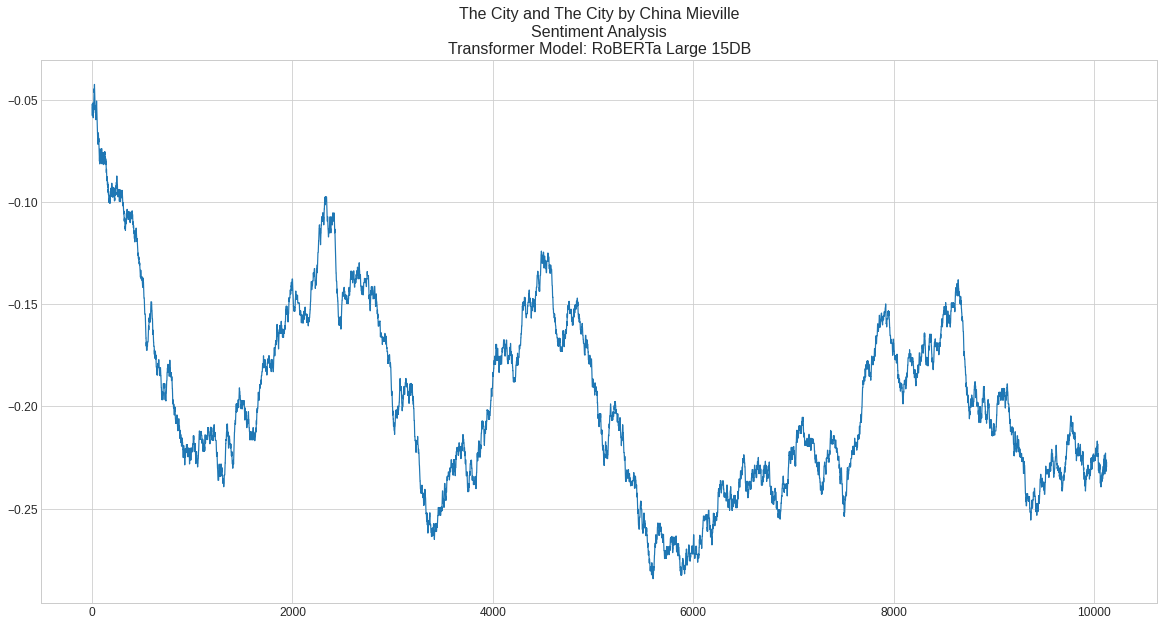

In [138]:
# Verify Plausiblity of new Sentiment Values by Plotting

novel_indx = 1
text_title_str = corpus_titles_ls[novel_indx]

win_10per = int(0.10*corpus_texts_dt[text_title_str].shape[0])
plot_title_str = f"{corpus_titles_dt[text_title_str][0]}\nSentiment Analysis\n{model_type} Model: {model_title}"
corpus_texts_dt[text_title_str][model_name].rolling(win_10per, center=True, min_periods=0).mean().plot(title=plot_title_str)
plt.show();

### **Save Checkpoint**

In [140]:
# Verify in SentimentArcs Root Directory

os.chdir('/gdrive/MyDrive/cdh/sentiment_arcs/')
!pwd

/gdrive/MyDrive/cdh/sentiment_arcs


In [141]:
# Save sentiment values to subdir_sentiments
save_filename = f'sentiment_raw_{Corpus_Type}_{Text_Type}_dnn2transformer.json'
write_dict_dfs(corpus_texts_dt, out_file=save_filename, out_dir=SUBDIR_SENTIMENT_RAW)
print(f'Saving Text_Type: {Text_Type}')
print(f'     Corpus_Type: {Corpus_Type}')
print('\n')

# Verify Dictionary was saved correctly by reading back the *.json datafile
test_dt = read_dict_dfs(in_file=save_filename, in_dir=SUBDIR_SENTIMENT_RAW)
print(f'These Text Titles:')
test_dt.keys()
print('\n')

corpus_texts_dt[corpus_titles_ls[0]].head()
print('\n')

test_dt['cmieville_thecityandthecity'].info()


Saving file to: ./sentiment_raw/novels_sentiment_new_raw/sentiment_raw_new_novels_dnn2transformer.json
Saving Text_Type: novels
     Corpus_Type: new


These Text Titles:


dict_keys(['cmieville_thecityandthecity', 'scollins_thehungergames1'])

,text_raw,text_clean,roberta15lg
0,"""THE TRIBUTES""",the tribute,0.997761
1,"When I wake up, the other side of the bed is cold.",when i wake up the other side of the bed be cold,-0.998957
2,"My fingers stretch out, seeking Prims warmth but finding only the rough canvas cover of the matt...",my finger stretch out seek prims warmth but find only the rough canvas cover of the mattress,-0.999391
3,She must have had bad dreams and climbed in with our mother.,she must have have bad dream and climb in with our mother,-0.997680
4,"Of course, she did.",of course she do,0.997088




<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10125 entries, 0 to 10124
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   roberta15lg  10125 non-null  float64
 1   text_clean   10125 non-null  object 
 2   text_raw     10125 non-null  object 
dtypes: float64(1), object(2)
memory usage: 237.4+ KB


## **Huggingface Distill BERT SST**

* https://www.machinecurve.com/index.php/2020/12/23/easy-sentiment-analysis-with-machine-learning-and-huggingface-transformers/

* https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english 

In [81]:
# BUG: Cannot reuse variable name 'sa_model', causes replicated results of first model declared (e.g. roberta15lg)
# sa_model = pipeline("sentiment-analysis")

# Huggingface default sentiment classifier model:
#   distilbert-base-uncased-finetuned-sst-2-english
classifier = pipeline("sentiment-analysis")

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english)


In [76]:
classifier("We are very happy to show you the 🤗 Transformers library.")
# sa_model("I love this")

[{'label': 'POSITIVE', 'score': 0.9997795224189758}]

In [79]:
# Define Model and Test

model_title = 'Huggingface DistilBERT'
model_name = 'huggingface'
model_type = 'Transformer'

# Test Words
print(f'Testing WORD Sentiment')
print('--------------------------------------------------')
for i, aword_str in enumerate(test_words_ls):

  word_sentiment_fl = classifier(aword_str)
  print(f'Word: {aword_str}\n    {word_sentiment_fl}\n')

# Test Sentences
print(f'\nTesting SENTENCE Sentiment')
print('--------------------------------------------------')
for i, asent_str in enumerate(test_sentences_ls):

  sent_sentiment_fl = labelscore2fl(classifier(asent_str), sa_model=classifier)
  print(f'Sentence: {asent_str}\n    {sent_sentiment_fl}\n')

Testing Huggingface DistilBERT Model for WORDS Sentiment
--------------------------------------------------
Word: Love
    [{'label': 'POSITIVE', 'score': 0.9998735189437866}]

Word: Hate
    [{'label': 'NEGATIVE', 'score': 0.9996899366378784}]

Word: bizarre
    [{'label': 'NEGATIVE', 'score': 0.9943822622299194}]

Word: strange
    [{'label': 'NEGATIVE', 'score': 0.9787243008613586}]

Word: furious
    [{'label': 'NEGATIVE', 'score': 0.999466598033905}]

Word: elated
    [{'label': 'POSITIVE', 'score': 0.9998383522033691}]

Word: curious
    [{'label': 'POSITIVE', 'score': 0.9969179630279541}]

Word: beserk
    [{'label': 'POSITIVE', 'score': 0.5606900453567505}]

Word: gambaro
    [{'label': 'POSITIVE', 'score': 0.916650116443634}]


Testing Huggingface DistilBERT Model for SENTENCES Sentiment
--------------------------------------------------
Sentence: I hate bad evil worthless Mondays.
    -0.9908758401870728

Sentence: I love Paris in the springtime
    0.9998341798782349

Senten

In [85]:
# Verify saving results to correct model name

print(f'Saving results to Model: {model_name}')

'huggingface'

In [80]:
%%time

# NOTE:   ~10m59s @?? on 20220301 Colab Pro (2 Novels)

# Compute Sentiments based upon SentimentR Lexicon

for i, atext in enumerate(corpus_texts_dt.keys()):
  print(f"Processing #{i}: {atext}")

  corpus_texts_dt[atext][model_name] = corpus_texts_dt[atext]['text_clean'].progress_apply(lambda x: labelscore2fl(classifier(x), sa_model=classifier))

Processing #0: cmieville_thecityandthecity
Processing #1: scollins_thehungergames1
CPU times: user 21min 43s, sys: 7.28 s, total: 21min 50s
Wall time: 10min 59s


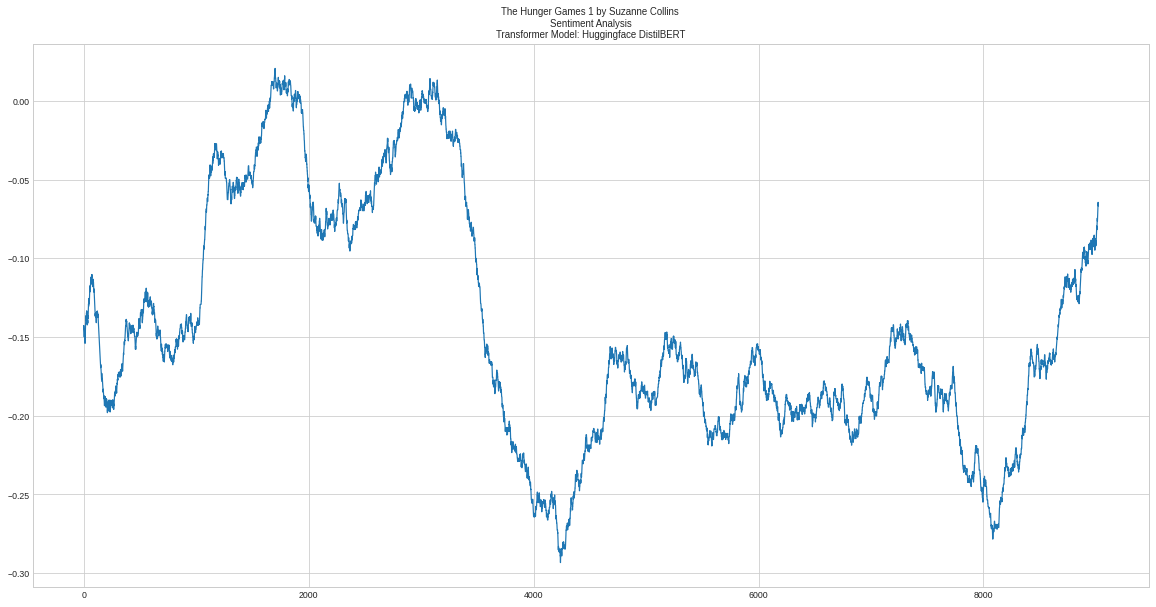

In [82]:
# Verify Plausiblity of new Sentiment Values by Plotting

novel_indx = 1
text_title_str = corpus_titles_ls[novel_indx]

win_10per = int(0.10*corpus_texts_dt[text_title_str].shape[0])
plot_title_str = f"{corpus_titles_dt[text_title_str][0]}\nSentiment Analysis\n{model_type} Model: {model_title}"
corpus_texts_dt[text_title_str][model_name].rolling(win_10per, center=True, min_periods=0).mean().plot(title=plot_title_str)
plt.show();

### **Save Checkpoint**

In [83]:
# Verify in SentimentArcs Root Directory

os.chdir('/gdrive/MyDrive/cdh/sentiment_arcs/')
!pwd

/gdrive/MyDrive/cdh/sentiment_arcs


In [84]:
# Save sentiment values to subdir_sentiments
# save_filename = f'sentiment_raw_{Corpus_Type}_{Text_Type}_dnn2transformer.json'
write_dict_dfs(corpus_texts_dt, out_file=FNAME_SENTIMENT_RAW, out_dir=SUBDIR_SENTIMENT_RAW)
print(f'Saving Text_Type: {Text_Type}')
print(f'     Corpus_Type: {Corpus_Type}')
print('\n')

# Verify Dictionary was saved correctly by reading back the *.json datafile
test_dt = read_dict_dfs(in_file=FNAME_SENTIMENT_RAW, in_dir=SUBDIR_SENTIMENT_RAW)
print(f'These Text Titles:')
test_dt.keys()
print('\n')

corpus_texts_dt[corpus_titles_ls[0]].head()
print('\n')

test_dt['cmieville_thecityandthecity'].info()


Saving file to: ./sentiment_raw/novels_sentiment_new_raw/sentiment_raw_novels_new_dnn2transformer.json
Saving Text_Type: novels
     Corpus_Type: new


These Text Titles:


dict_keys(['cmieville_thecityandthecity', 'scollins_thehungergames1'])

,roberta15lg,text_clean,text_raw,huggingface
0,-0.963685,annotation,Annotation,-0.936181
1,-0.997429,the city be beszel a rundown metropolis on the eastern edge of europe,"The city is Beszel, a rundown metropolis on the eastern edge of Europe.",0.739575
2,0.997683,the other city be ul qoma a modern eastern european boomtown despite be a bite of a internationa...,"The other city is Ul Qoma, a modern Eastern European boomtown, despite being a bit of an interna...",0.970969
3,0.998308,what the two city share and what they do not be the deliciously evocative conundrum at the heart...,"What the two cities share, and what they don't, is the deliciously evocative conundrum at the he...",0.998701
4,0.998878,mieville be good know a a modern fantasist and urbanist but from book to book he be try on diffe...,"Mieville is well known as a modern fantasist (and urbanist), but from book to book he's tried on...",0.998341




<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10125 entries, 0 to 10124
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   huggingface  10125 non-null  float64
 1   roberta15lg  10125 non-null  float64
 2   text_clean   10125 non-null  object 
 3   text_raw     10125 non-null  object 
dtypes: float64(2), object(2)
memory usage: 316.5+ KB


## **NLPTown Multilingual BERT (5 cats)**

* https://huggingface.co/nlptown/bert-base-multilingual-uncased-sentiment

In [52]:
# NLPTown: Multilingual trained BERT Model

sa_nlptown = pipeline("sentiment-analysis",model="nlptown/bert-base-multilingual-uncased-sentiment")

# Test
print(sa_nlptown("I love this!"))

Downloading:   0%|          | 0.00/953 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/638M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/39.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/851k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

[{'label': '5 stars', 'score': 0.9236248135566711}]


In [107]:
# Define Model and Test

model_title = 'NLPTown MultiBERT'
model_name = 'nlptown'
model_type = 'Transformer'

# Test Words
print(f'Testing WORD Sentiment')
print('--------------------------------------------------')
for i, aword_str in enumerate(test_words_ls):

  word_sentiment_fl = sa_nlptown(aword_str)
  print(f'Word: {aword_str}\n    {word_sentiment_fl}\n')

# Test Sentences
print(f'\nTesting SENTENCE Sentiment')
print('--------------------------------------------------')
for i, asent_str in enumerate(test_sentences_ls):

  sent_sentiment_fl = labelscore2fl(sa_nlptown(asent_str), sa_model=sa_nlptown)
  print(f'Sentence: {asent_str}\n    {sent_sentiment_fl:.3f}\n')

Testing WORD Sentiment
--------------------------------------------------
Word: Love
    [{'label': '5 stars', 'score': 0.6595041155815125}]

Word: Hate
    [{'label': '1 star', 'score': 0.6935485005378723}]

Word: bizarre
    [{'label': '1 star', 'score': 0.3379122018814087}]

Word: strange
    [{'label': '1 star', 'score': 0.28947728872299194}]

Word: furious
    [{'label': '1 star', 'score': 0.6228678822517395}]

Word: elated
    [{'label': '2 stars', 'score': 0.34351804852485657}]

Word: curious
    [{'label': '3 stars', 'score': 0.3870857357978821}]

Word: beserk
    [{'label': '5 stars', 'score': 0.3120572566986084}]

Word: gambaro
    [{'label': '3 stars', 'score': 0.253237783908844}]


Testing SENTENCE Sentiment
--------------------------------------------------
Sentence: I hate bad evil worthless Mondays.
    0.885

Sentence: I love Paris in the springtime
    4.628

Sentence: It was Wednesday.
    0.313

Sentence: You are a disgusting pig - I hate you.
    0.899

Sentence: Wh

In [54]:
# Verify saving results to correct model name

print(f'Saving results to Model: {model_name}')

Saving results to Model: nlptown


In [58]:
%%time

# NOTE:   9m05s @16:40 on 20220301 Colab Pro (1 Novel: cmieville_thecityandthecity)
#         ~8m07s @16:49 on 20220201 Colab Pro (1 Novel: scollins_thehungergames1)

# Compute Sentiments based upon SentimentR Lexicon

for i, atext in enumerate(corpus_texts_dt.keys()):
  print(f"Processing #{i}: {atext}")

  corpus_texts_dt[atext][model_name] = corpus_texts_dt[atext]['text_clean'].progress_apply(lambda x: labelscore2fl(sa_nlptown(x), sa_model=sa_nlptown))

Processing #0: cmieville_thecityandthecity


  0%|          | 0/10125 [00:00<?, ?it/s]

Processing #1: scollins_thehungergames1


  0%|          | 0/9021 [00:00<?, ?it/s]

CPU times: user 34min 5s, sys: 13.5 s, total: 34min 18s
Wall time: 17min 12s


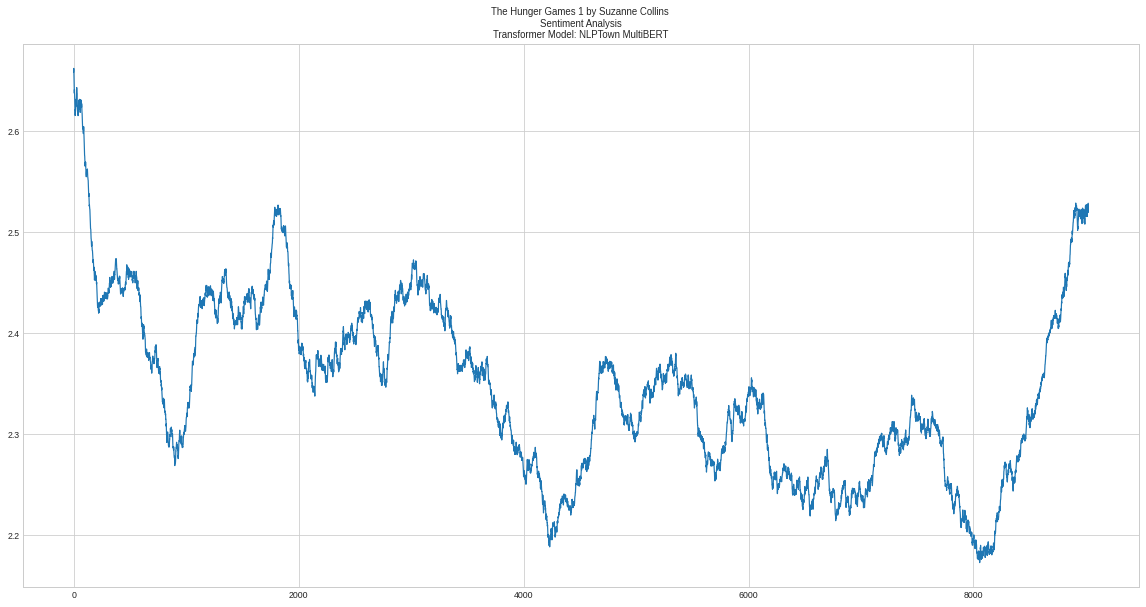

In [108]:
# Verify Plausiblity of new Sentiment Values by Plotting

novel_indx = 1
text_title_str = corpus_titles_ls[novel_indx]

win_10per = int(0.10*corpus_texts_dt[text_title_str].shape[0])
plot_title_str = f"{corpus_titles_dt[text_title_str][0]}\nSentiment Analysis\n{model_type} Model: {model_title}"
corpus_texts_dt[text_title_str][model_name].rolling(win_10per, center=True, min_periods=0).mean().plot(title=plot_title_str)
plt.show();

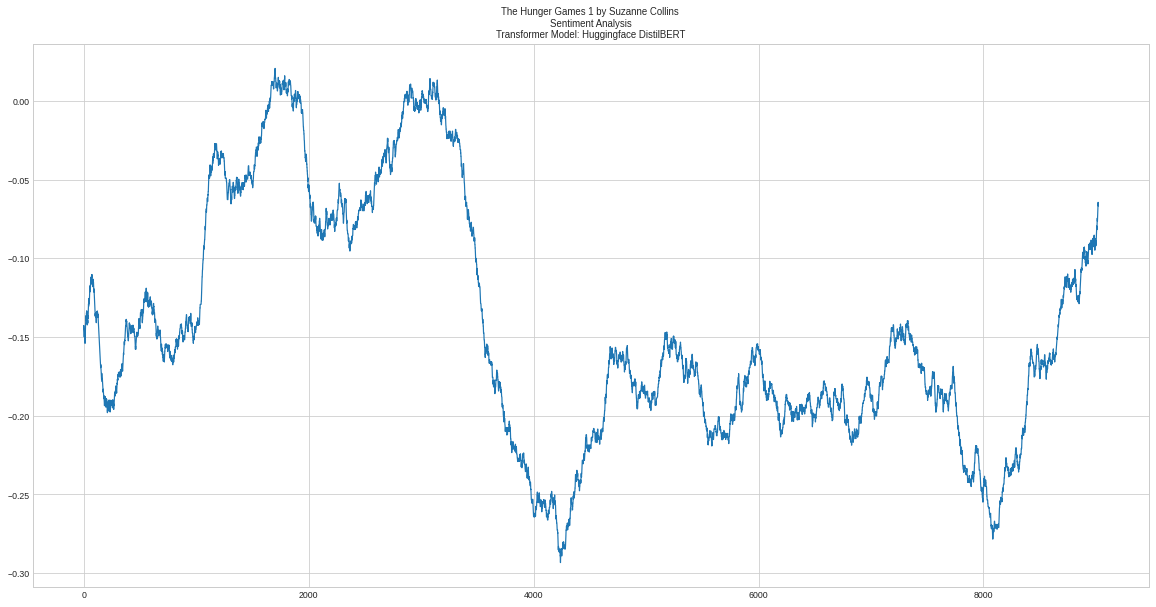

In [ ]:
# Verify Plausiblity of new Sentiment Values by Plotting

novel_indx = 1
text_title_str = corpus_titles_ls[novel_indx]

win_10per = int(0.10*corpus_texts_dt[text_title_str].shape[0])
plot_title_str = f"{corpus_titles_dt[text_title_str][0]}\nSentiment Analysis\n{model_type} Model: {model_title}"
corpus_texts_dt[text_title_str][model_name].rolling(win_10per, center=True, min_periods=0).mean().plot(title=plot_title_str)
plt.show();

### **Save Checkpoint**

In [109]:
# Verify in SentimentArcs Root Directory

os.chdir('/gdrive/MyDrive/cdh/sentiment_arcs/')
!pwd

/gdrive/MyDrive/cdh/sentiment_arcs


In [110]:
# Save sentiment values to subdir_sentiments
# save_filename = f'sentiment_raw_{Corpus_Type}_{Text_Type}_dnn2transformer.json'
write_dict_dfs(corpus_texts_dt, out_file=FNAME_SENTIMENT_RAW, out_dir=SUBDIR_SENTIMENT_RAW)
print(f'Saving Text_Type: {Text_Type}')
print(f'     Corpus_Type: {Corpus_Type}')
print('\n')

# Verify Dictionary was saved correctly by reading back the *.json datafile
test_dt = read_dict_dfs(in_file=FNAME_SENTIMENT_RAW, in_dir=SUBDIR_SENTIMENT_RAW)
print(f'These Text Titles:')
test_dt.keys()
print('\n')

corpus_texts_dt[corpus_titles_ls[0]].head()
print('\n')

test_dt['cmieville_thecityandthecity'].info()


Saving file to: ./sentiment_raw/novels_sentiment_new_raw/sentiment_raw_novels_new_dnn2transformer.json
Saving Text_Type: novels
     Corpus_Type: new


These Text Titles:


dict_keys(['cmieville_thecityandthecity', 'scollins_thehungergames1'])

,huggingface,roberta15lg,text_clean,text_raw,nlptown,yelp
0,-0.936181,-0.963685,annotation,Annotation,2.264484,1
1,0.739575,-0.997429,the city be beszel a rundown metropolis on the eastern edge of europe,"The city is Beszel, a rundown metropolis on the eastern edge of Europe.",3.329419,1
2,0.970969,0.997683,the other city be ul qoma a modern eastern european boomtown despite be a bite of a internationa...,"The other city is Ul Qoma, a modern Eastern European boomtown, despite being a bit of an interna...",2.346609,1
3,0.998701,0.998308,what the two city share and what they do not be the deliciously evocative conundrum at the heart...,"What the two cities share, and what they don't, is the deliciously evocative conundrum at the he...",3.328189,1
4,0.998341,0.998878,mieville be good know a a modern fantasist and urbanist but from book to book he be try on diffe...,"Mieville is well known as a modern fantasist (and urbanist), but from book to book he's tried on...",3.306802,1




<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10125 entries, 0 to 10124
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   huggingface  10125 non-null  float64
 1   nlptown      10125 non-null  float64
 2   roberta15lg  10125 non-null  float64
 3   text_clean   10125 non-null  object 
 4   text_raw     10125 non-null  object 
 5   yelp         10125 non-null  int64  
dtypes: float64(3), int64(1), object(2)
memory usage: 474.7+ KB


## **Yelp Finetuned BERT (5 cats)**

* https://huggingface.co/gilf/english-yelp-sentiment

In [62]:
# Yelp Trained BERT Sentiment Classifier

# from transformers import AutoTokenizer, AutoModelForSequenceClassification (above)
tokenizer = AutoTokenizer.from_pretrained("gilf/english-yelp-sentiment")

sa_yelp = AutoModelForSequenceClassification.from_pretrained("gilf/english-yelp-sentiment")

Downloading:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/748 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/208k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/413M [00:00<?, ?B/s]

In [87]:
# Test

text_str = "I love sunny days and happy puppy dogs."
text_enc = tokenizer(text_str, return_tensors='pt')
text_sentiment = sa_yelp(**text_enc)
print(f'Yelp SA Model:\n  INPUT: {text_str}\n  SENTIMENT: {text_sentiment}')
print(f'  TYPE: {type(text_sentiment)}')
text_smax_ls_ls = text_sentiment.logits.softmax(dim=-1).tolist()
text_smax_ls = text_smax_ls_ls[0]
print(type(text_smax_ls[0]))
print(f'  sMAX: {text_smax_ls}')
max_val = max(text_smax_ls)
max_indx = text_smax_ls.index(max_val)
print(f'   MAX: {max_val} at indx={max_indx}')

Yelp SA Model:
  INPUT: I love sunny days and happy puppy dogs.
  SENTIMENT: SequenceClassifierOutput(loss=None, logits=tensor([[-2.6225, -1.4072,  0.8254,  1.6360,  1.3209]],
       grad_fn=<AddmmBackward0>), hidden_states=None, attentions=None)
  TYPE: <class 'transformers.modeling_outputs.SequenceClassifierOutput'>
<class 'float'>
  sMAX: [0.006325008347630501, 0.021322447806596756, 0.19882354140281677, 0.4471935033798218, 0.32633548974990845]
   MAX: 0.4471935033798218 at indx=3


In [97]:
"""
def logitstensor2sentiment(hugseqclass_output):
  '''
  Given a Huggingface SequenceClassifierOutput logits tensor
  Return Sentiment and assoc softmax probability values
  '''

  text_smax_ls_ls = hugseqclass_output.logits.softmax(dim=-1).tolist()
  text_smax_ls = text_smax_ls_ls[0]
  # print(type(text_smax_ls[0]))
  # print(f'  sMAX: {text_smax_ls}')
  max_val = max(text_smax_ls)            # Probability based upon logits %
  max_indx = text_smax_ls.index(max_val) # Sentiment (starting from 0 up)
  val_scale = len(text_smax_ls)
  # print(f'   MAX: {max_val} at indx={max_indx}')

  return max_indx, val_scale, max_val
""";

# Test
text_str = "I love sunny days and happy puppy dogs."
text_enc = tokenizer(text_str, return_tensors='pt')
text_sentiment = sa_yelp(**text_enc)

sentiment_val, sentiment_scale, sentiment_prob = logitstensor2sentiment(text_sentiment)
print(f'SENTENCE: {text_str}')
print(f'          Sentiment: {sentiment_val} out of {sentiment_scale} (prob={sentiment_prob:.3f})')

SENTENCE: I love sunny days and happy puppy dogs.
          Sentiment: 3 out of 5 (prob=0.447)


In [113]:
# Define Model and Test

model_title = 'Yelp BERT'
model_name = 'yelp'
model_type = 'Transformer'

# Test Words
print(f'Testing WORD Sentiment')
print('--------------------------------------------------')
for i, aword_str in enumerate(test_words_ls):

  aword_enc = tokenizer(aword_str, return_tensors='pt')
  logits_tensor = sa_yelp(**aword_enc)
  sentiment_val, sentiment_scale, sentiment_prob = logitstensor2sentiment(logits_tensor)
  print(f'Word: {aword_str}\n    Sentiment: {sentiment_val} out of {sentiment_scale} (prob={sentiment_prob:.3f})\n')

# Test Sentences
print(f'\nTesting SENTENCE Sentiment')
print('--------------------------------------------------')
for i, asent_str in enumerate(test_sentences_ls):

  asent_enc = tokenizer(asent_str, return_tensors='pt')
  logits_tensor = sa_yelp(**asent_enc)
  sentiment_val, sentiment_scale, sentiment_prob = logitstensor2sentiment(logits_tensor)
  print(f'Sentence: {aword_str}\n    Sentiment: {sentiment_val} out of {sentiment_scale} (prob={sentiment_prob:.3f})\n')

Testing WORD Sentiment
--------------------------------------------------
Word: Love
    Sentiment: 4 out of 5 (prob=0.550)

Word: Hate
    Sentiment: 0 out of 5 (prob=0.770)

Word: bizarre
    Sentiment: 2 out of 5 (prob=0.475)

Word: strange
    Sentiment: 2 out of 5 (prob=0.550)

Word: furious
    Sentiment: 0 out of 5 (prob=0.856)

Word: elated
    Sentiment: 2 out of 5 (prob=0.294)

Word: curious
    Sentiment: 2 out of 5 (prob=0.499)

Word: beserk
    Sentiment: 2 out of 5 (prob=0.370)

Word: gambaro
    Sentiment: 3 out of 5 (prob=0.543)


Testing SENTENCE Sentiment
--------------------------------------------------
Sentence: gambaro
    Sentiment: 0 out of 5 (prob=0.297)

Sentence: gambaro
    Sentiment: 3 out of 5 (prob=0.485)

Sentence: gambaro
    Sentiment: 2 out of 5 (prob=0.517)

Sentence: gambaro
    Sentiment: 0 out of 5 (prob=0.938)

Sentence: gambaro
    Sentiment: 4 out of 5 (prob=0.751)

Sentence: gambaro
    Sentiment: 1 out of 5 (prob=0.371)



In [130]:
# Verify saving results to correct model name

print(f'Saving results to Model: {model_name}')

sent_test_str = "I hate Mondays and bad doctors."
print(f"Sentence: {sent_test_str}\n {logitstensor2sentiment(sa_hinglish(**tokenizer(sent_test_str, return_tensors='pt')))[0]}")

Saving results to Model: hinglish
Sentence: I hate Mondays and bad doctors.
 1


In [120]:
%%time

# NOTE:    10m45s @17:39 on 20220301 Colab Pro (1 Novel: cmieville_thecityandthecity: 10.1k sentences)
#          10m19s @17:48 on 20220301 Colab Pro (1 Novel: scollins_thehungergames1: 9.0k sentences)

# Compute Sentiments based upon SentimentR Lexicon

for i, atext in enumerate(corpus_texts_dt.keys()):
  print(f"Processing #{i}: {atext}")

  corpus_texts_dt[atext][model_name] = corpus_texts_dt[atext]['text_clean'].progress_apply(lambda x: logitstensor2sentiment(sa_yelp(**tokenizer(x, return_tensors='pt')))[0])

Processing #0: cmieville_thecityandthecity


  0%|          | 0/10125 [00:00<?, ?it/s]

Processing #1: scollins_thehungergames1


  0%|          | 0/9021 [00:00<?, ?it/s]

CPU times: user 41min 19s, sys: 23.4 s, total: 41min 42s
Wall time: 21min 4s


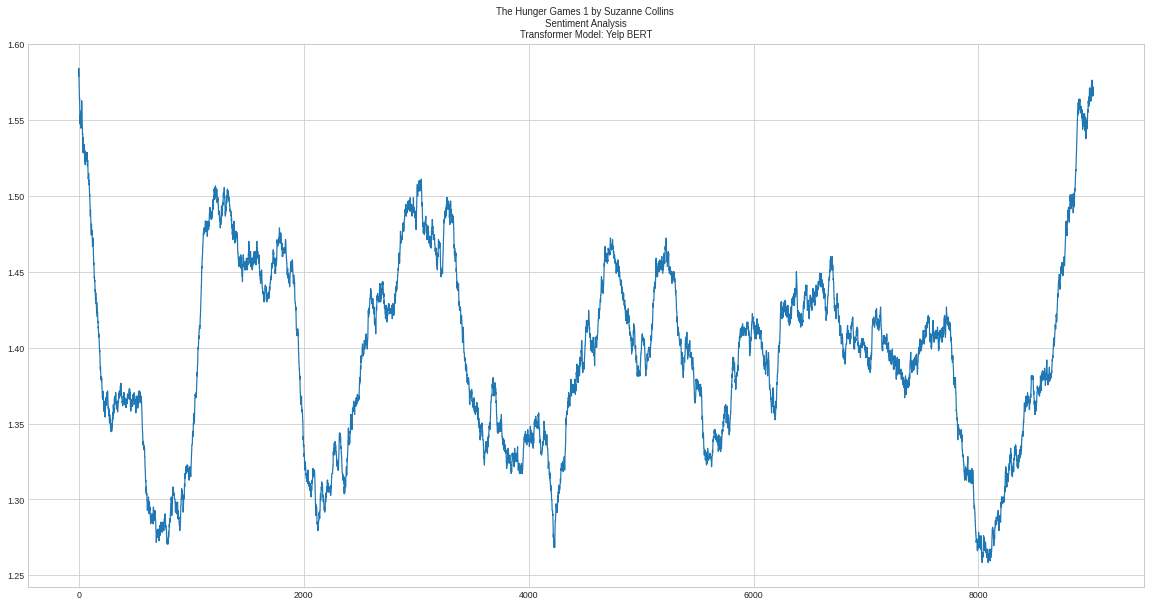

In [122]:
# Verify Plausiblity of new Sentiment Values by Plotting

novel_indx = 1
text_title_str = corpus_titles_ls[novel_indx]

win_10per = int(0.10*corpus_texts_dt[text_title_str].shape[0])
plot_title_str = f"{corpus_titles_dt[text_title_str][0]}\nSentiment Analysis\n{model_type} Model: {model_title}"
corpus_texts_dt[text_title_str][model_name].rolling(win_10per, center=True, min_periods=0).mean().plot(title=plot_title_str)
plt.show();

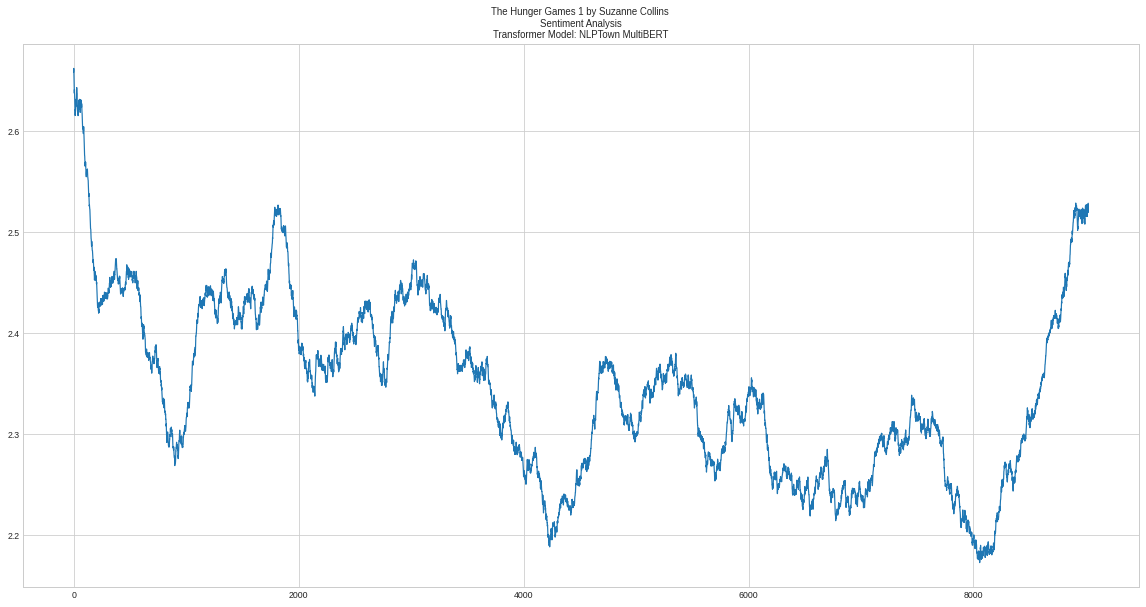

In [111]:
# Verify Plausiblity of new Sentiment Values by Plotting

novel_indx = 1
text_title_str = corpus_titles_ls[novel_indx]

win_10per = int(0.10*corpus_texts_dt[text_title_str].shape[0])
plot_title_str = f"{corpus_titles_dt[text_title_str][0]}\nSentiment Analysis\n{model_type} Model: {model_title}"
corpus_texts_dt[text_title_str][model_name].rolling(win_10per, center=True, min_periods=0).mean().plot(title=plot_title_str)
plt.show();

### **Save Checkpoint**

In [123]:
# Verify in SentimentArcs Root Directory

os.chdir('/gdrive/MyDrive/cdh/sentiment_arcs/')
!pwd

/gdrive/MyDrive/cdh/sentiment_arcs


In [124]:
# Save sentiment values to subdir_sentiments
# save_filename = f'sentiment_raw_{Corpus_Type}_{Text_Type}_dnn2transformer.json'
write_dict_dfs(corpus_texts_dt, out_file=FNAME_SENTIMENT_RAW, out_dir=SUBDIR_SENTIMENT_RAW)
print(f'Saving Text_Type: {Text_Type}')
print(f'     Corpus_Type: {Corpus_Type}')
print('\n')

# Verify Dictionary was saved correctly by reading back the *.json datafile
test_dt = read_dict_dfs(in_file=FNAME_SENTIMENT_RAW, in_dir=SUBDIR_SENTIMENT_RAW)
print(f'These Text Titles:')
test_dt.keys()
print('\n')

corpus_texts_dt[corpus_titles_ls[0]].head()
print('\n')

test_dt['cmieville_thecityandthecity'].info()


Saving file to: ./sentiment_raw/novels_sentiment_new_raw/sentiment_raw_novels_new_dnn2transformer.json
Saving Text_Type: novels
     Corpus_Type: new


These Text Titles:


dict_keys(['cmieville_thecityandthecity', 'scollins_thehungergames1'])

,huggingface,roberta15lg,text_clean,text_raw,nlptown,yelp
0,-0.936181,-0.963685,annotation,Annotation,2.264484,2
1,0.739575,-0.997429,the city be beszel a rundown metropolis on the eastern edge of europe,"The city is Beszel, a rundown metropolis on the eastern edge of Europe.",3.329419,1
2,0.970969,0.997683,the other city be ul qoma a modern eastern european boomtown despite be a bite of a internationa...,"The other city is Ul Qoma, a modern Eastern European boomtown, despite being a bit of an interna...",2.346609,4
3,0.998701,0.998308,what the two city share and what they do not be the deliciously evocative conundrum at the heart...,"What the two cities share, and what they don't, is the deliciously evocative conundrum at the he...",3.328189,2
4,0.998341,0.998878,mieville be good know a a modern fantasist and urbanist but from book to book he be try on diffe...,"Mieville is well known as a modern fantasist (and urbanist), but from book to book he's tried on...",3.306802,4




<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10125 entries, 0 to 10124
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   huggingface  10125 non-null  float64
 1   nlptown      10125 non-null  float64
 2   roberta15lg  10125 non-null  float64
 3   text_clean   10125 non-null  object 
 4   text_raw     10125 non-null  object 
 5   yelp         10125 non-null  int64  
dtypes: float64(3), int64(1), object(2)
memory usage: 474.7+ KB


## **Hinglish Mixed Code BERT (3 cats)**

* https://huggingface.co/rohanrajpal/bert-base-multilingual-codemixed-cased-sentiment

In [125]:
# Hindi-English Code Switching BERT Model

# from transformers import AutoTokenizer, AutoModelForSequenceClassification (above)

tokenizer = AutoTokenizer.from_pretrained("rohanrajpal/bert-base-multilingual-codemixed-cased-sentiment")

sa_hinglish = AutoModelForSequenceClassification.from_pretrained("rohanrajpal/bert-base-multilingual-codemixed-cased-sentiment")

Downloading:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/828 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/972k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/679M [00:00<?, ?B/s]

In [126]:
# Test

text_str = "I love sunny days and happy puppy dogs."
text_enc = tokenizer(text_str, return_tensors='pt')
text_sentiment = sa_hinglish(**text_enc)
print(f'Hinglish SA Model:\n  INPUT: {text_str}\n  SENTIMENT: {text_sentiment}')
print(f'  TYPE: {type(text_sentiment)}')
text_smax_ls_ls = text_sentiment.logits.softmax(dim=-1).tolist()
text_smax_ls = text_smax_ls_ls[0]
print(type(text_smax_ls[0]))
print(f'  sMAX: {text_smax_ls}')
max_val = max(text_smax_ls)
max_indx = text_smax_ls.index(max_val)
print(f'   MAX: {max_val} at indx={max_indx}')

Hinglish SA Model:
  INPUT: I love sunny days and happy puppy dogs.
  SENTIMENT: SequenceClassifierOutput(loss=None, logits=tensor([[-0.8385, -2.0611,  2.9085]], grad_fn=<AddmmBackward0>), hidden_states=None, attentions=None)
  TYPE: <class 'transformers.modeling_outputs.SequenceClassifierOutput'>
<class 'float'>
  sMAX: [0.022890940308570862, 0.006740636192262173, 0.9703684449195862]
   MAX: 0.9703684449195862 at indx=2


In [127]:
"""
def logitstensor2sentiment(hugseqclass_output):
  '''
  Given a Huggingface SequenceClassifierOutput logits tensor
  Return Sentiment and assoc softmax probability values
  '''

  text_smax_ls_ls = hugseqclass_output.logits.softmax(dim=-1).tolist()
  text_smax_ls = text_smax_ls_ls[0]
  # print(type(text_smax_ls[0]))
  # print(f'  sMAX: {text_smax_ls}')
  max_val = max(text_smax_ls)            # Probability based upon logits %
  max_indx = text_smax_ls.index(max_val) # Sentiment (starting from 0 up)
  val_scale = len(text_smax_ls)
  # print(f'   MAX: {max_val} at indx={max_indx}')

  return max_indx, val_scale, max_val
""";

# Test
text_str = "I love sunny days and happy puppy dogs."
text_enc = tokenizer(text_str, return_tensors='pt')
text_sentiment = sa_hinglish(**text_enc)

sentiment_val, sentiment_scale, sentiment_prob = logitstensor2sentiment(text_sentiment)
print(f'SENTENCE: {text_str}')
print(f'          Sentiment: {sentiment_val} out of {sentiment_scale} (prob={sentiment_prob:.3f})')

"\ndef logitstensor2sentiment(hugseqclass_output):\n  '''\n  Given a Huggingface SequenceClassifierOutput logits tensor\n  Return Sentiment and assoc softmax probability values\n  '''\n\n  text_smax_ls_ls = hugseqclass_output.logits.softmax(dim=-1).tolist()\n  text_smax_ls = text_smax_ls_ls[0]\n  # print(type(text_smax_ls[0]))\n  # print(f'  sMAX: {text_smax_ls}')\n  max_val = max(text_smax_ls)            # Probability based upon logits %\n  max_indx = text_smax_ls.index(max_val) # Sentiment (starting from 0 up)\n  val_scale = len(text_smax_ls)\n  # print(f'   MAX: {max_val} at indx={max_indx}')\n\n  return max_indx, val_scale, max_val\n"

SENTENCE: I love sunny days and happy puppy dogs.
          Sentiment: 2 out of 3 (prob=0.970)


In [128]:
# Define Model and Test

model_title = 'Hinglish Dual Code BERT'
model_name = 'hinglish'
model_type = 'Transformer'

# Test Words
print(f'Testing WORD Sentiment')
print('--------------------------------------------------')
for i, aword_str in enumerate(test_words_ls):

  aword_enc = tokenizer(aword_str, return_tensors='pt')
  logits_tensor = sa_hinglish(**aword_enc)
  sentiment_val, sentiment_scale, sentiment_prob = logitstensor2sentiment(logits_tensor)
  print(f'Word: {aword_str}\n    Sentiment: {sentiment_val} out of {sentiment_scale} (prob={sentiment_prob:.3f})\n')

# Test Sentences
print(f'\nTesting SENTENCE Sentiment')
print('--------------------------------------------------')
for i, asent_str in enumerate(test_sentences_ls):

  asent_enc = tokenizer(asent_str, return_tensors='pt')
  logits_tensor = sa_hinglish(**asent_enc)
  sentiment_val, sentiment_scale, sentiment_prob = logitstensor2sentiment(logits_tensor)
  print(f'Sentence: {aword_str}\n    Sentiment: {sentiment_val} out of {sentiment_scale} (prob={sentiment_prob:.3f})\n')

Testing WORD Sentiment
--------------------------------------------------
Word: Love
    Sentiment: 2 out of 3 (prob=0.940)

Word: Hate
    Sentiment: 1 out of 3 (prob=0.733)

Word: bizarre
    Sentiment: 2 out of 3 (prob=0.772)

Word: strange
    Sentiment: 2 out of 3 (prob=0.742)

Word: furious
    Sentiment: 2 out of 3 (prob=0.943)

Word: elated
    Sentiment: 2 out of 3 (prob=0.754)

Word: curious
    Sentiment: 2 out of 3 (prob=0.511)

Word: beserk
    Sentiment: 0 out of 3 (prob=0.702)

Word: gambaro
    Sentiment: 0 out of 3 (prob=0.601)


Testing SENTENCE Sentiment
--------------------------------------------------
Sentence: gambaro
    Sentiment: 1 out of 3 (prob=0.880)

Sentence: gambaro
    Sentiment: 2 out of 3 (prob=0.958)

Sentence: gambaro
    Sentiment: 2 out of 3 (prob=0.584)

Sentence: gambaro
    Sentiment: 1 out of 3 (prob=0.804)

Sentence: gambaro
    Sentiment: 2 out of 3 (prob=0.971)

Sentence: gambaro
    Sentiment: 2 out of 3 (prob=0.516)



In [131]:
# Verify saving results to correct model name

print(f'Saving results to Model: {model_name}')

sent_test_str = "I hate Mondays and bad doctors."
print(f"Sentence: {sent_test_str}\n {logitstensor2sentiment(sa_hinglish(**tokenizer(sent_test_str, return_tensors='pt')))[0]}")

Saving results to Model: hinglish
Sentence: I hate Mondays and bad doctors.
 1


In [ ]:
%%time

# NOTE:    8m06s @17:39 on 20220301 Colab Pro (1 Novel: cmieville_thecityandthecity: 10.1k sentences)
#         10m00s @17:48 on 20220301 Colab Pro (1 Novel: scollins_thehungergames1: 9.0k sentences)

# Compute Sentiments based upon SentimentR Lexicon

for i, atext in enumerate(corpus_texts_dt.keys()):
  print(f"Processing #{i}: {atext}")

  corpus_texts_dt[atext][model_name] = corpus_texts_dt[atext]['text_clean'].progress_apply(lambda x: logitstensor2sentiment(sa_hinglish(**tokenizer(x, return_tensors='pt')))[0])

Processing #0: cmieville_thecityandthecity


  0%|          | 0/10125 [00:00<?, ?it/s]

Processing #1: scollins_thehungergames1


  0%|          | 0/9021 [00:00<?, ?it/s]

CPU times: user 35min, sys: 19.9 s, total: 35min 20s
Wall time: 17min 36s


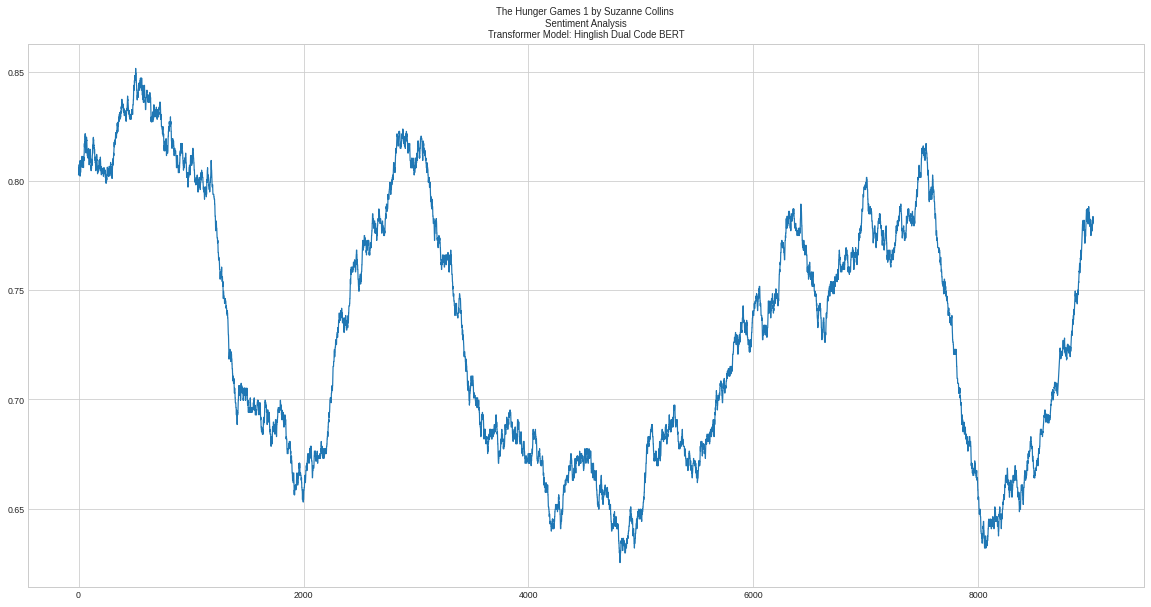

In [ ]:
# Verify Plausiblity of new Sentiment Values by Plotting

novel_indx = 1
text_title_str = corpus_titles_ls[novel_indx]

win_10per = int(0.10*corpus_texts_dt[text_title_str].shape[0])
plot_title_str = f"{corpus_titles_dt[text_title_str][0]}\nSentiment Analysis\n{model_type} Model: {model_title}"
corpus_texts_dt[text_title_str][model_name].rolling(win_10per, center=True, min_periods=0).mean().plot(title=plot_title_str)
plt.show();

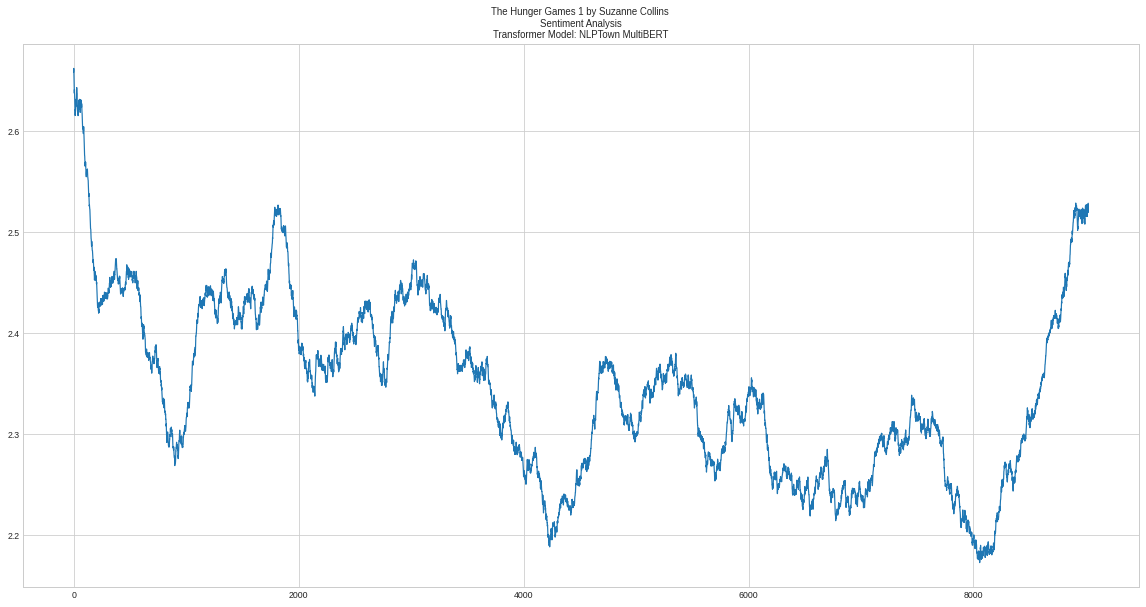

In [ ]:
# Verify Plausiblity of new Sentiment Values by Plotting

novel_indx = 1
text_title_str = corpus_titles_ls[novel_indx]

win_10per = int(0.10*corpus_texts_dt[text_title_str].shape[0])
plot_title_str = f"{corpus_titles_dt[text_title_str][0]}\nSentiment Analysis\n{model_type} Model: {model_title}"
corpus_texts_dt[text_title_str][model_name].rolling(win_10per, center=True, min_periods=0).mean().plot(title=plot_title_str)
plt.show();

### **Save Checkpoint**

In [ ]:
# Verify in SentimentArcs Root Directory

os.chdir('/gdrive/MyDrive/cdh/sentiment_arcs/')
!pwd

/gdrive/MyDrive/cdh/sentiment_arcs


In [ ]:
# Save sentiment values to subdir_sentiments
# save_filename = f'sentiment_raw_{Corpus_Type}_{Text_Type}_dnn2transformer.json'
write_dict_dfs(corpus_texts_dt, out_file=FNAME_SENTIMENT_RAW, out_dir=SUBDIR_SENTIMENT_RAW)
print(f'Saving Text_Type: {Text_Type}')
print(f'     Corpus_Type: {Corpus_Type}')
print('\n')

# Verify Dictionary was saved correctly by reading back the *.json datafile
test_dt = read_dict_dfs(in_file=FNAME_SENTIMENT_RAW, in_dir=SUBDIR_SENTIMENT_RAW)
print(f'These Text Titles:')
test_dt.keys()
print('\n')

corpus_texts_dt[corpus_titles_ls[0]].head()
print('\n')

test_dt['cmieville_thecityandthecity'].info()


Saving file to: ./sentiment_raw/novels_sentiment_new_raw/sentiment_raw_novels_new_dnn2transformer.json
Saving Text_Type: novels
     Corpus_Type: new


These Text Titles:


dict_keys(['cmieville_thecityandthecity', 'scollins_thehungergames1'])

,huggingface,roberta15lg,text_clean,text_raw,nlptown,yelp,hinglish
0,-0.936181,-0.963685,annotation,Annotation,2.264484,2,0
1,0.739575,-0.997429,the city be beszel a rundown metropolis on the eastern edge of europe,"The city is Beszel, a rundown metropolis on the eastern edge of Europe.",3.329419,1,0
2,0.970969,0.997683,the other city be ul qoma a modern eastern european boomtown despite be a bite of a internationa...,"The other city is Ul Qoma, a modern Eastern European boomtown, despite being a bit of an interna...",2.346609,4,2
3,0.998701,0.998308,what the two city share and what they do not be the deliciously evocative conundrum at the heart...,"What the two cities share, and what they don't, is the deliciously evocative conundrum at the he...",3.328189,2,2
4,0.998341,0.998878,mieville be good know a a modern fantasist and urbanist but from book to book he be try on diffe...,"Mieville is well known as a modern fantasist (and urbanist), but from book to book he's tried on...",3.306802,4,2




<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10125 entries, 0 to 10124
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   hinglish     10125 non-null  int64  
 1   huggingface  10125 non-null  float64
 2   nlptown      10125 non-null  float64
 3   roberta15lg  10125 non-null  float64
 4   text_clean   10125 non-null  object 
 5   text_raw     10125 non-null  object 
 6   yelp         10125 non-null  int64  
dtypes: float64(3), int64(2), object(2)
memory usage: 553.8+ KB


## **BERT IMDB Sentiment (2 cats)**

* https://huggingface.co/abhishek/autonlp-imdb_sentiment_classification-31154 (metrics)

In [ ]:
# BERT Sentiment Classifier fine-tuned on IMDB

# from transformers import AutoTokenizer, AutoModelForSequenceClassification (above)
tokenizer = AutoTokenizer.from_pretrained("abhishek/autonlp-imdb_sentiment_classification-31154")

sa_imdb = AutoModelForSequenceClassification.from_pretrained("abhishek/autonlp-imdb_sentiment_classification-31154")

Downloading:   0%|          | 0.00/283 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/816 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/780k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/239 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/313M [00:00<?, ?B/s]

In [ ]:
# sentiment_analysis = pipeline("sentiment-analysis",model="abhishek/autonlp-imdb_sentiment_classification-31154")

In [ ]:
# Test

text_str = "I love sunny days and happy puppy dogs."
text_enc = tokenizer(text_str, return_tensors='pt')
text_sentiment = sa_imdb(**text_enc)
print(f'IMDB SA Model:\n  INPUT: {text_str}\n  SENTIMENT: {text_sentiment}')
print(f'  TYPE: {type(text_sentiment)}')
text_smax_ls_ls = text_sentiment.logits.softmax(dim=-1).tolist()
text_smax_ls = text_smax_ls_ls[0]
print(type(text_smax_ls[0]))
print(f'  sMAX: {text_smax_ls}')
max_val = max(text_smax_ls)
max_indx = text_smax_ls.index(max_val)
print(f'   MAX: {max_val} at indx={max_indx}')

IMDB SA Model:
  INPUT: I love sunny days and happy puppy dogs.
  SENTIMENT: SequenceClassifierOutput(loss=None, logits=tensor([[-2.4812,  2.5836]], grad_fn=<AddmmBackward0>), hidden_states=None, attentions=None)
  TYPE: <class 'transformers.modeling_outputs.SequenceClassifierOutput'>
<class 'float'>
  sMAX: [0.006275228690356016, 0.9937247633934021]
   MAX: 0.9937247633934021 at indx=1


In [ ]:
"""
def logitstensor2sentiment(hugseqclass_output):
  '''
  Given a Huggingface SequenceClassifierOutput logits tensor
  Return Sentiment and assoc softmax probability values
  '''

  text_smax_ls_ls = hugseqclass_output.logits.softmax(dim=-1).tolist()
  text_smax_ls = text_smax_ls_ls[0]
  # print(type(text_smax_ls[0]))
  # print(f'  sMAX: {text_smax_ls}')
  max_val = max(text_smax_ls)            # Probability based upon logits %
  max_indx = text_smax_ls.index(max_val) # Sentiment (starting from 0 up)
  val_scale = len(text_smax_ls)
  # print(f'   MAX: {max_val} at indx={max_indx}')

  return max_indx, val_scale, max_val
""";

# Test
text_str = "I love sunny days and happy puppy dogs."
text_enc = tokenizer(text_str, return_tensors='pt')
text_sentiment = sa_imdb(**text_enc)

sentiment_val, sentiment_scale, sentiment_prob = logitstensor2sentiment(text_sentiment)
print(f'SENTENCE: {text_str}')
print(f'          Sentiment: {sentiment_val} out of {sentiment_scale} (prob={sentiment_prob:.3f})')

"\ndef logitstensor2sentiment(hugseqclass_output):\n  '''\n  Given a Huggingface SequenceClassifierOutput logits tensor\n  Return Sentiment and assoc softmax probability values\n  '''\n\n  text_smax_ls_ls = hugseqclass_output.logits.softmax(dim=-1).tolist()\n  text_smax_ls = text_smax_ls_ls[0]\n  # print(type(text_smax_ls[0]))\n  # print(f'  sMAX: {text_smax_ls}')\n  max_val = max(text_smax_ls)            # Probability based upon logits %\n  max_indx = text_smax_ls.index(max_val) # Sentiment (starting from 0 up)\n  val_scale = len(text_smax_ls)\n  # print(f'   MAX: {max_val} at indx={max_indx}')\n\n  return max_indx, val_scale, max_val\n"

SENTENCE: I love sunny days and happy puppy dogs.
          Sentiment: 1 out of 2 (prob=0.994)


In [ ]:
# Define Model and Test

model_title = 'IMDB BERT'
model_name = 'imdb2way'
model_type = 'Transformer'

# Test Words
print(f'Testing WORD Sentiment')
print('--------------------------------------------------')
for i, aword_str in enumerate(test_words_ls):

  aword_enc = tokenizer(aword_str, return_tensors='pt')
  logits_tensor = sa_imdb(**aword_enc)
  sentiment_val, sentiment_scale, sentiment_prob = logitstensor2sentiment(logits_tensor)
  print(f'Word: {aword_str}\n    Sentiment: {sentiment_val} out of {sentiment_scale} (prob={sentiment_prob:.3f})\n')

# Test Sentences
print(f'\nTesting SENTENCE Sentiment')
print('--------------------------------------------------')
for i, asent_str in enumerate(test_sentences_ls):

  asent_enc = tokenizer(asent_str, return_tensors='pt')
  logits_tensor = sa_imdb(**asent_enc)
  sentiment_val, sentiment_scale, sentiment_prob = logitstensor2sentiment(logits_tensor)
  print(f'Sentence: {aword_str}\n    Sentiment: {sentiment_val} out of {sentiment_scale} (prob={sentiment_prob:.3f})\n')

Testing WORD Sentiment
--------------------------------------------------
Word: Love
    Sentiment: 1 out of 2 (prob=0.930)

Word: Hate
    Sentiment: 0 out of 2 (prob=0.734)

Word: bizarre
    Sentiment: 0 out of 2 (prob=0.999)

Word: strange
    Sentiment: 1 out of 2 (prob=0.966)

Word: furious
    Sentiment: 1 out of 2 (prob=0.996)

Word: elated
    Sentiment: 0 out of 2 (prob=0.995)

Word: curious
    Sentiment: 1 out of 2 (prob=0.997)

Word: beserk
    Sentiment: 1 out of 2 (prob=0.782)

Word: gambaro
    Sentiment: 1 out of 2 (prob=0.941)


Testing SENTENCE Sentiment
--------------------------------------------------
Sentence: gambaro
    Sentiment: 0 out of 2 (prob=0.998)

Sentence: gambaro
    Sentiment: 1 out of 2 (prob=0.997)

Sentence: gambaro
    Sentiment: 1 out of 2 (prob=0.979)

Sentence: gambaro
    Sentiment: 0 out of 2 (prob=0.973)

Sentence: gambaro
    Sentiment: 1 out of 2 (prob=0.999)

Sentence: gambaro
    Sentiment: 0 out of 2 (prob=0.997)



In [ ]:
# Verify saving results to correct model name

print(f'Saving results to Model: {model_name}')

sent_test_str = "I hate Mondays and bad doctors."
print(f"Sentence: {sent_test_str}\n {logitstensor2sentiment(sa_imdb(**tokenizer(sent_test_str, return_tensors='pt')))[0]}")

Saving results to Model: imdb2way
Sentence: I hate Mondays and bad doctors.
 0


In [ ]:
%%time

# NOTE:    10m45s @17:39 on 20220301 Colab Pro (1 Novel: cmieville_thecityandthecity: 10.1k sentences)
#          10m00s @17:48 on 20220301 Colab Pro (1 Novel: scollins_thehungergames1: 9.0k sentences)

# Compute Sentiments based upon SentimentR Lexicon

for i, atext in enumerate(corpus_texts_dt.keys()):
  print(f"Processing #{i}: {atext}")

  corpus_texts_dt[atext][model_name] = corpus_texts_dt[atext]['text_clean'].progress_apply(lambda x: logitstensor2sentiment(sa_imdb(**tokenizer(x, return_tensors='pt')))[0])

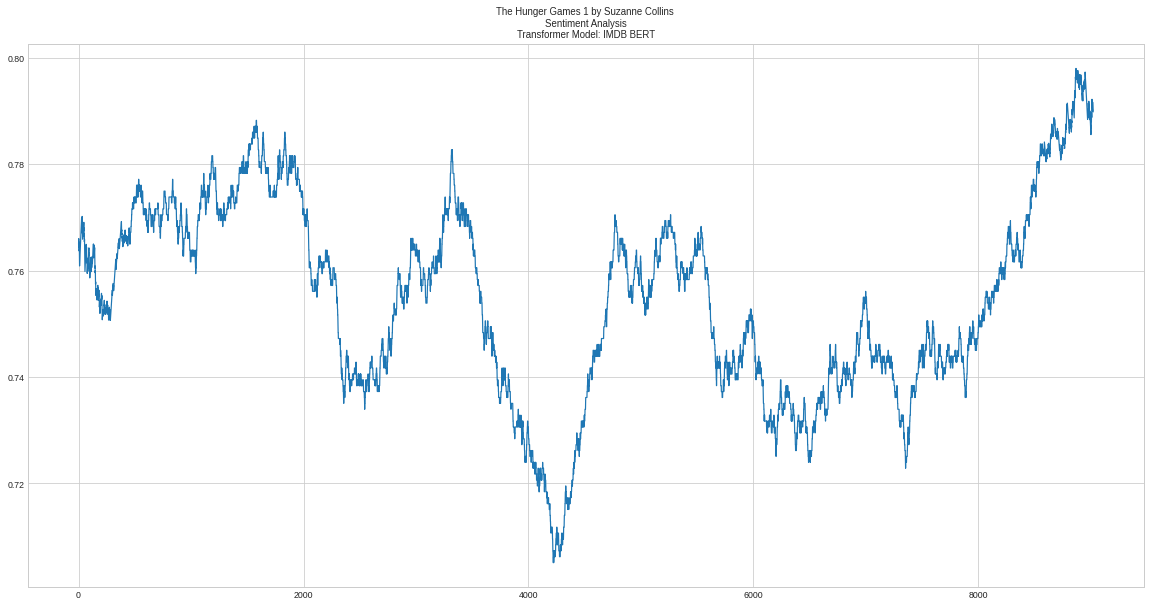

In [ ]:
# Verify Plausiblity of new Sentiment Values by Plotting

novel_indx = 1
text_title_str = corpus_titles_ls[novel_indx]

win_10per = int(0.10*corpus_texts_dt[text_title_str].shape[0])
plot_title_str = f"{corpus_titles_dt[text_title_str][0]}\nSentiment Analysis\n{model_type} Model: {model_title}"
corpus_texts_dt[text_title_str][model_name].rolling(win_10per, center=True, min_periods=0).mean().plot(title=plot_title_str)
plt.show();

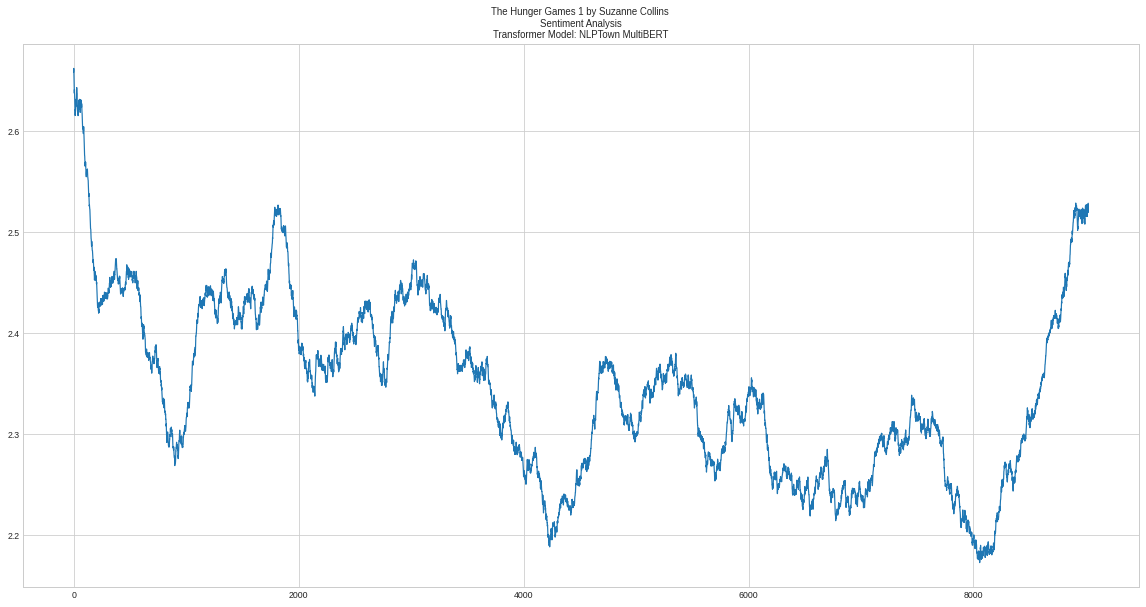

In [ ]:
# Verify Plausiblity of new Sentiment Values by Plotting

novel_indx = 1
text_title_str = corpus_titles_ls[novel_indx]

win_10per = int(0.10*corpus_texts_dt[text_title_str].shape[0])
plot_title_str = f"{corpus_titles_dt[text_title_str][0]}\nSentiment Analysis\n{model_type} Model: {model_title}"
corpus_texts_dt[text_title_str][model_name].rolling(win_10per, center=True, min_periods=0).mean().plot(title=plot_title_str)
plt.show();

### **Save Checkpoint**

In [ ]:
# Verify in SentimentArcs Root Directory

os.chdir('/gdrive/MyDrive/cdh/sentiment_arcs/')
!pwd

/gdrive/MyDrive/cdh/sentiment_arcs


In [ ]:
# Save sentiment values to subdir_sentiments
# save_filename = f'sentiment_raw_{Corpus_Type}_{Text_Type}_dnn2transformer.json'
write_dict_dfs(corpus_texts_dt, out_file=FNAME_SENTIMENT_RAW, out_dir=SUBDIR_SENTIMENT_RAW)
print(f'Saving Text_Type: {Text_Type}')
print(f'     Corpus_Type: {Corpus_Type}')
print('\n')

# Verify Dictionary was saved correctly by reading back the *.json datafile
test_dt = read_dict_dfs(in_file=FNAME_SENTIMENT_RAW, in_dir=SUBDIR_SENTIMENT_RAW)
print(f'These Text Titles:')
test_dt.keys()
print('\n')

corpus_texts_dt[corpus_titles_ls[0]].head()
print('\n')

test_dt['cmieville_thecityandthecity'].info()


Saving file to: ./sentiment_raw/novels_sentiment_new_raw/sentiment_raw_novels_new_dnn2transformer.json
Saving Text_Type: novels
     Corpus_Type: new


These Text Titles:


dict_keys(['cmieville_thecityandthecity', 'scollins_thehungergames1'])

,huggingface,roberta15lg,text_clean,text_raw,nlptown,yelp,hinglish,imdb2way
0,-0.936181,-0.963685,annotation,Annotation,2.264484,2,0,1
1,0.739575,-0.997429,the city be beszel a rundown metropolis on the eastern edge of europe,"The city is Beszel, a rundown metropolis on the eastern edge of Europe.",3.329419,1,0,1
2,0.970969,0.997683,the other city be ul qoma a modern eastern european boomtown despite be a bite of a internationa...,"The other city is Ul Qoma, a modern Eastern European boomtown, despite being a bit of an interna...",2.346609,4,2,1
3,0.998701,0.998308,what the two city share and what they do not be the deliciously evocative conundrum at the heart...,"What the two cities share, and what they don't, is the deliciously evocative conundrum at the he...",3.328189,2,2,1
4,0.998341,0.998878,mieville be good know a a modern fantasist and urbanist but from book to book he be try on diffe...,"Mieville is well known as a modern fantasist (and urbanist), but from book to book he's tried on...",3.306802,4,2,1




<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10125 entries, 0 to 10124
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   hinglish     10125 non-null  int64  
 1   huggingface  10125 non-null  float64
 2   imdb2way     10125 non-null  int64  
 3   nlptown      10125 non-null  float64
 4   roberta15lg  10125 non-null  float64
 5   text_clean   10125 non-null  object 
 6   text_raw     10125 non-null  object 
 7   yelp         10125 non-null  int64  
dtypes: float64(3), int64(3), object(2)
memory usage: 632.9+ KB


## **T5Base 50k Finetuned IMDB Sentiment Extraction (2 cats)**

* https://huggingface.co/mrm8488/t5-small-finetuned-imdb-sentiment 
* https://github.com/patil-suraj/exploring-T5/blob/master/t5_fine_tuning.ipynb

In [ ]:
from transformers import AutoModelForSeq2SeqLM

In [ ]:
# T5 Base Fine-tuned on IMDB50k

# from transformers import AutoTokenizer, AutoModelForSeq2SeqLM (above)
tokenizer = AutoTokenizer.from_pretrained("mrm8488/t5-small-finetuned-imdb-sentiment")

sa_t5imdb = AutoModelForSeq2SeqLM.from_pretrained("mrm8488/t5-small-finetuned-imdb-sentiment")

Downloading:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/773k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.74k [00:00<?, ?B/s]

ValueError: ignored

In [ ]:
# Test

text_str = "I love sunny days and happy puppy dogs."
text_enc = tokenizer(text_str, return_tensors='pt')
text_sentiment = sa_t5imdb(**text_enc)
print(f'Yelp SA Model:\n  INPUT: {text_str}\n  SENTIMENT: {text_sentiment}')
print(f'  TYPE: {type(text_sentiment)}')
text_smax_ls_ls = text_sentiment.logits.softmax(dim=-1).tolist()
text_smax_ls = text_smax_ls_ls[0]
print(type(text_smax_ls[0]))
print(f'  sMAX: {text_smax_ls}')
max_val = max(text_smax_ls)
max_indx = text_smax_ls.index(max_val)
print(f'   MAX: {max_val} at indx={max_indx}')

In [ ]:
"""
def logitstensor2sentiment(hugseqclass_output):
  '''
  Given a Huggingface SequenceClassifierOutput logits tensor
  Return Sentiment and assoc softmax probability values
  '''

  text_smax_ls_ls = hugseqclass_output.logits.softmax(dim=-1).tolist()
  text_smax_ls = text_smax_ls_ls[0]
  # print(type(text_smax_ls[0]))
  # print(f'  sMAX: {text_smax_ls}')
  max_val = max(text_smax_ls)            # Probability based upon logits %
  max_indx = text_smax_ls.index(max_val) # Sentiment (starting from 0 up)
  val_scale = len(text_smax_ls)
  # print(f'   MAX: {max_val} at indx={max_indx}')

  return max_indx, val_scale, max_val
""";

# Test
text_str = "I love sunny days and happy puppy dogs."
text_enc = tokenizer(text_str, return_tensors='pt')
text_sentiment = sa_t5imdb(**text_enc)

sentiment_val, sentiment_scale, sentiment_prob = logitstensor2sentiment(text_sentiment)
print(f'SENTENCE: {text_str}')
print(f'          Sentiment: {sentiment_val} out of {sentiment_scale} (prob={sentiment_prob:.3f})')

In [ ]:
# Define Model and Test

model_title = 'T5 Base IMDB50K'
model_name = 't5imdb50k'
model_type = 'Transformer'

# Test Words
print(f'Testing WORD Sentiment')
print('--------------------------------------------------')
for i, aword_str in enumerate(test_words_ls):

  aword_enc = tokenizer(aword_str, return_tensors='pt')
  logits_tensor = sa_t5imdb(**aword_enc)
  sentiment_val, sentiment_scale, sentiment_prob = logitstensor2sentiment(logits_tensor)
  print(f'Word: {aword_str}\n    Sentiment: {sentiment_val} out of {sentiment_scale} (prob={sentiment_prob:.3f})\n')

# Test Sentences
print(f'\nTesting SENTENCE Sentiment')
print('--------------------------------------------------')
for i, asent_str in enumerate(test_sentences_ls):

  asent_enc = tokenizer(asent_str, return_tensors='pt')
  logits_tensor = sa_t5imdb(**asent_enc)
  sentiment_val, sentiment_scale, sentiment_prob = logitstensor2sentiment(logits_tensor)
  print(f'Sentence: {aword_str}\n    Sentiment: {sentiment_val} out of {sentiment_scale} (prob={sentiment_prob:.3f})\n')

In [ ]:
# Verify saving results to correct model name

print(f'Saving results to Model: {model_name}')

sent_test_str = "I hate Mondays and bad doctors."
print(f"Sentence: {sent_test_str}\n {logitstensor2sentiment(sa_t5imdb(**tokenizer(sent_test_str, return_tensors='pt')))[0]}")

In [ ]:
%%time

# NOTE:    10m45s @17:39 on 20220301 Colab Pro (1 Novel: cmieville_thecityandthecity: 10.1k sentences)
#          10m00s @17:48 on 20220301 Colab Pro (1 Novel: scollins_thehungergames1: 9.0k sentences)

# Compute Sentiments based upon SentimentR Lexicon

for i, atext in enumerate(corpus_texts_dt.keys()):
  print(f"Processing #{i}: {atext}")

  corpus_texts_dt[atext][model_name] = corpus_texts_dt[atext]['text_clean'].progress_apply(lambda x: logitstensor2sentiment(sa_t5imdb(**tokenizer(x, return_tensors='pt')))[0])

In [ ]:
# Verify Plausiblity of new Sentiment Values by Plotting

novel_indx = 1
text_title_str = corpus_titles_ls[novel_indx]

win_10per = int(0.10*corpus_texts_dt[text_title_str].shape[0])
plot_title_str = f"{corpus_titles_dt[text_title_str][0]}\nSentiment Analysis\n{model_type} Model: {model_title}"
corpus_texts_dt[text_title_str][model_name].rolling(win_10per, center=True, min_periods=0).mean().plot(title=plot_title_str)
plt.show();

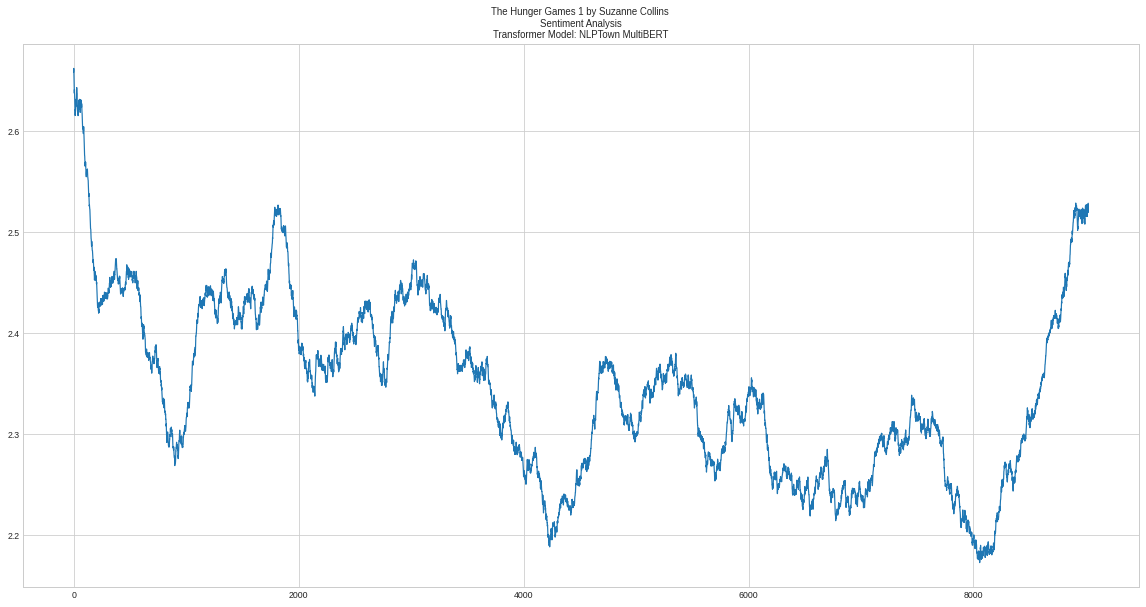

In [ ]:
# Verify Plausiblity of new Sentiment Values by Plotting

novel_indx = 1
text_title_str = corpus_titles_ls[novel_indx]

win_10per = int(0.10*corpus_texts_dt[text_title_str].shape[0])
plot_title_str = f"{corpus_titles_dt[text_title_str][0]}\nSentiment Analysis\n{model_type} Model: {model_title}"
corpus_texts_dt[text_title_str][model_name].rolling(win_10per, center=True, min_periods=0).mean().plot(title=plot_title_str)
plt.show();

### **Save Checkpoint**

In [ ]:
# Verify in SentimentArcs Root Directory

os.chdir('/gdrive/MyDrive/cdh/sentiment_arcs/')
!pwd

In [ ]:
# Save sentiment values to subdir_sentiments
# save_filename = f'sentiment_raw_{Corpus_Type}_{Text_Type}_dnn2transformer.json'
write_dict_dfs(corpus_texts_dt, out_file=FNAME_SENTIMENT_RAW, out_dir=SUBDIR_SENTIMENT_RAW)
print(f'Saving Text_Type: {Text_Type}')
print(f'     Corpus_Type: {Corpus_Type}')
print('\n')

# Verify Dictionary was saved correctly by reading back the *.json datafile
test_dt = read_dict_dfs(in_file=FNAME_SENTIMENT_RAW, in_dir=SUBDIR_SENTIMENT_RAW)
print(f'These Text Titles:')
test_dt.keys()
print('\n')

corpus_texts_dt[corpus_titles_ls[0]].head()
print('\n')

test_dt['cmieville_thecityandthecity'].info()


**[SKIP] to next Section**

In [ ]:
def get_t5imdb50k_sentiment(text):
  '''
  Given a plain text string
  Return a binary integer [-1,1] (negative,positive) sentiment value
  '''

  input_ids = tokenizer.encode(text + '</s>', return_tensors='pt')

  output = model.generate(input_ids=input_ids,
               max_length=2)

  dec = [tokenizer.decode(ids) for ids in output]
  label = dec[0]

  if 'positive' in label:
    score_int = 1
  elif 'negative' in label:
    score_int = -1
  else:
    score_int = 0

  return score_int

# Test
# get_sentiment("I dislike a lot that film")

In [ ]:
# Test Directly

test_result_pos = get_t5imdb50k_sentiment('I absolutely love this great and wonderful opportunity to enjoy lovely and good things')
test_result_pos # [0]['label']
print('\n')
test_result_neu = get_t5imdb50k_sentiment('blank')
test_result_neu # [0]['label']
print('\n')
test_result_neg = get_t5imdb50k_sentiment('I hate bad evil dislike')
test_result_neg # [0]['label']

1

-1

-1

In [ ]:
# Test Indirectly

# Production
sentence_str = 'I love wonderful good things'
polarity = get_t5imdb50k_sentiment(sentence_str)
print(f'\nPositive Sentence Polarity: {polarity}\n    Text: {sentence_str}')

sentence_str = 'This'
polarity = get_t5imdb50k_sentiment(sentence_str)
print(f'\nNeutral Sentence Polarity: {polarity}\n    Text: {sentence_str}')

sentence_str = 'I hate your stinking guts you filthy lying stealing cheating bastard.'
polarity = get_t5imdb50k_sentiment(sentence_str)
print(f'\nNegative Sentence Polarity: {polarity}\n    Text: {sentence_str}')


Positive Sentence Polarity: 1
    Text: I love wonderful good things

Neutral Sentence Polarity: 0
    Text: This

Negative Sentence Polarity: -1
    Text: I hate your stinking guts you filthy lying stealing cheating bastard.


In [ ]:
%%time

# NOTE: ~5 minutes runtime
#       3m16s mins (20210915 at 13:26) Colab Pro: GPU+RAM (jausten_prideandprejudice)

corpus_sents_trans_df['t5imdb50k'] = corpus_sents_trans_df['sent_raw'].apply(lambda x: get_t5imdb50k_sentiment(x[:510]))
corpus_sents_trans_df.head()

CPU times: user 6min 30s, sys: 2.62 s, total: 6min 32s
Wall time: 3min 16s


In [ ]:
# Save Preprocessed Corpus Sentences DataFrame

# author_str = ''.join(CORPUS_AUTHOR.split()).lower()
title_str = ''.join(CORPUS_TITLE.split()).lower()
datetime_now = datetime.utcnow().strftime("%Y%m%d_%H%M")

# Sentences
corpus_sents_filename = f'sum_sentiments_sents_trans_{author_abbr_str}_{title_str}.csv'
print(f'Saving to file: {corpus_sents_filename}')

corpus_sents_trans_df.to_csv(corpus_sents_filename)

Saving to file: sum_sentiments_sents_trans_vnabokov_palefire-cantos.csv


## **RoBERTa XLM Twitter 8 Mulilingual (3 cats, slow)**

* http://huggingface.co/cardiffnlp/twitter-xlm-roberta-base-sentiment

In [ ]:
# !pip install sentencepiece

In [ ]:
# Yelp Trained BERT Sentiment Classifier

# from transformers import AutoTokenizer, AutoModelForSequenceClassification (above)
tokenizer = AutoTokenizer.from_pretrained("gilf/english-yelp-sentiment")

sa_yelp = AutoModelForSequenceClassification.from_pretrained("gilf/english-yelp-sentiment")

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
  
tokenizer = AutoTokenizer.from_pretrained("cardiffnlp/twitter-xlm-roberta-base-sentiment")

model = AutoModelForSequenceClassification.from_pretrained("cardiffnlp/twitter-xlm-roberta-base-sentiment")

Downloading:   0%|          | 0.00/841 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/150 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

In [ ]:
sentiment_analysis = pipeline("sentiment-analysis",model="cardiffnlp/twitter-xlm-roberta-base-sentiment")


In [ ]:
# Test Directly

test_result_pos = sentiment_analysis('I absolutely love this great and wonderful opportunity to enjoy lovely and good things')
test_result_pos # [0]['label']
print('\n')
test_result_neu = sentiment_analysis('blank')
test_result_neu # [0]['label']
print('\n')
test_result_neg = sentiment_analysis('I hate bad evil dislike')
test_result_neg # [0]['label']

[{'label': 'Positive', 'score': 0.9455917477607727}]

[{'label': 'Neutral', 'score': 0.4261215627193451}]

[{'label': 'Negative', 'score': 0.9544662237167358}]

In [ ]:
# Test English

sentence_str = 'I love wonderful good things'
polarity = threeway_probability2sentiment(sentence_str, sentiment_analysis)
print(f'\nPositive Sentence Polarity: {polarity}\n    Text: {sentence_str}')

sentence_str = 'It is what it is'
polarity = threeway_probability2sentiment(sentence_str, sentiment_analysis)
print(f'\nNeutral Sentence Polarity: {polarity}\n    Text: {sentence_str}')

sentence_str = 'I hate your stinking guts you filthy lying stealing cheating bastard.'
polarity = threeway_probability2sentiment(sentence_str, sentiment_analysis)
print(f'\nNegative Sentence Polarity: {polarity}\n    Text: {sentence_str}')


Positive Sentence Polarity: 1.9224474430084229
    Text: I love wonderful good things

Neutral Sentence Polarity: 0.5882502794265747
    Text: It is what it is

Negative Sentence Polarity: -1.9525753259658813
    Text: I hate your stinking guts you filthy lying stealing cheating bastard.


In [ ]:
# Test French

test_result_pos = sentiment_analysis("Je déteste le livre.")
test_result_pos # [0]['label']
print('\n')
test_result_pos = sentiment_analysis("Bien.")
test_result_pos # [0]['label']
print('\n')
test_result_pos = sentiment_analysis("Mal.")
test_result_pos # [0]['label']
print('\n')
test_result_pos = sentiment_analysis("J'aime et j'apprécie les journées ensoleillées avec des enfants rieurs qui jouent joyeusement pendant l'été insouciant.")
test_result_pos # [0]['label']
print('\n')
test_result_pos = sentiment_analysis("Il est.")
test_result_pos # [0]['label']
print('\n')
test_result_neu = sentiment_analysis("Cette phrase est vide.")
test_result_neu # [0]['label']
print('\n')
test_result_neg = sentiment_analysis("Je déteste et méprise le mal affreux qui infecte notre organisation.")
test_result_neg # [0]['label']

[{'label': 'Negative', 'score': 0.961158275604248}]

[{'label': 'Positive', 'score': 0.7114393711090088}]

[{'label': 'Negative', 'score': 0.7386776804924011}]

[{'label': 'Positive', 'score': 0.9386938810348511}]

[{'label': 'Neutral', 'score': 0.5012816190719604}]

[{'label': 'Negative', 'score': 0.9402057528495789}]

[{'label': 'Negative', 'score': 0.9703734517097473}]

In [ ]:
%%time

# NOTE: started 9:05
#       28m50s mins (20210915 at 13:26) Colab Pro: GPU+RAM (jausten_prideandprejudice)

corpus_sents_trans_df['robertaxml8lang'] = corpus_sents_trans_df['sent_raw'].apply(lambda x: threeway_probability2sentiment(x[:510], sentiment_analysis))
corpus_sents_trans_df.head()

CPU times: user 14min 38s, sys: 4.75 s, total: 14min 43s
Wall time: 7min 20s


In [ ]:
# Save Preprocessed Corpus Sentences DataFrame

# author_str = ''.join(CORPUS_AUTHOR.split()).lower()
title_str = ''.join(CORPUS_TITLE.split()).lower()
datetime_now = datetime.utcnow().strftime("%Y%m%d_%H%M")

# Sentences
corpus_sents_filename = f'sum_sentiments_sents_trans_{author_abbr_str}_{title_str}.csv'
print(f'Saving to file: {corpus_sents_filename}')

corpus_sents_trans_df.to_csv(corpus_sents_filename)

In [ ]:
corpus_sents_filename

'sum_sentiments_sents_trans_vnabokov_palefire-cantos.csv'

In [ ]:
!mv sum_sentiments_sents_trans_vnabokov_palefire-cantos.csv sum_sentiments_sents_trans_jausten_prideandprejudice.csvreader

# **END OF NOTEBOOK**